In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128


Looking in indexes: https://download.pytorch.org/whl/cu128


In [5]:
# CORONARY ARTERY SEGMENTATION - UPORZĄDKOWANY NOTEBOOK
# Analiza i segmentacja tętnic wieńcowych z nowymi architekturami

# Instalacja wymaganych pakietów
!pip install tqdm tensorboard torchmetrics albumentations opencv-python scikit-image matplotlib  

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached torchmetrics-1.8.0-py3-none-any.whl.metadata (21 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
  Using cached scikit_image-0.25.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached grpcio-1.74.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached markdown-3.8.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached protobuf-6.31.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.w

PyTorch używa GPU: NVIDIA GeForce RTX 5090
🔧 Device: cuda
Ścieżka danych: /home/ives/rafal/notebooks/data
Znaleziono 1000 obrazów (.jpg)
Znaleziono 1000 masek (.png)
1000 par obraz-maska
\nANALIZA PRÓBEK:
\n--- PRÓBKA 1 ---
Obraz: (512, 512), dtype: uint8
  Min: 42, Max: 210, Mean: 114.09
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne wartości: [  0 255]
  Piksele pozytywne: 20340/786432 (2.59%)
\n--- PRÓBKA 10 ---
Obraz: (512, 512, 3), dtype: uint8
  Min: 28, Max: 167, Mean: 98.83
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne wartości: [  0 255]
  Piksele pozytywne: 29253/786432 (3.72%)
\n--- PRÓBKA 100 ---
Obraz: (512, 512), dtype: uint8
  Min: 43, Max: 234, Mean: 117.03
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne wartości: [  0 255]
  Piksele pozytywne: 15516/786432 (1.97%)
\n--- PRÓBKA 1000 ---
Obraz: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255, Mean: 110.17
Maska: (512, 512, 3), dtype: uint8
  Min: 0, Max: 255
  Unikalne

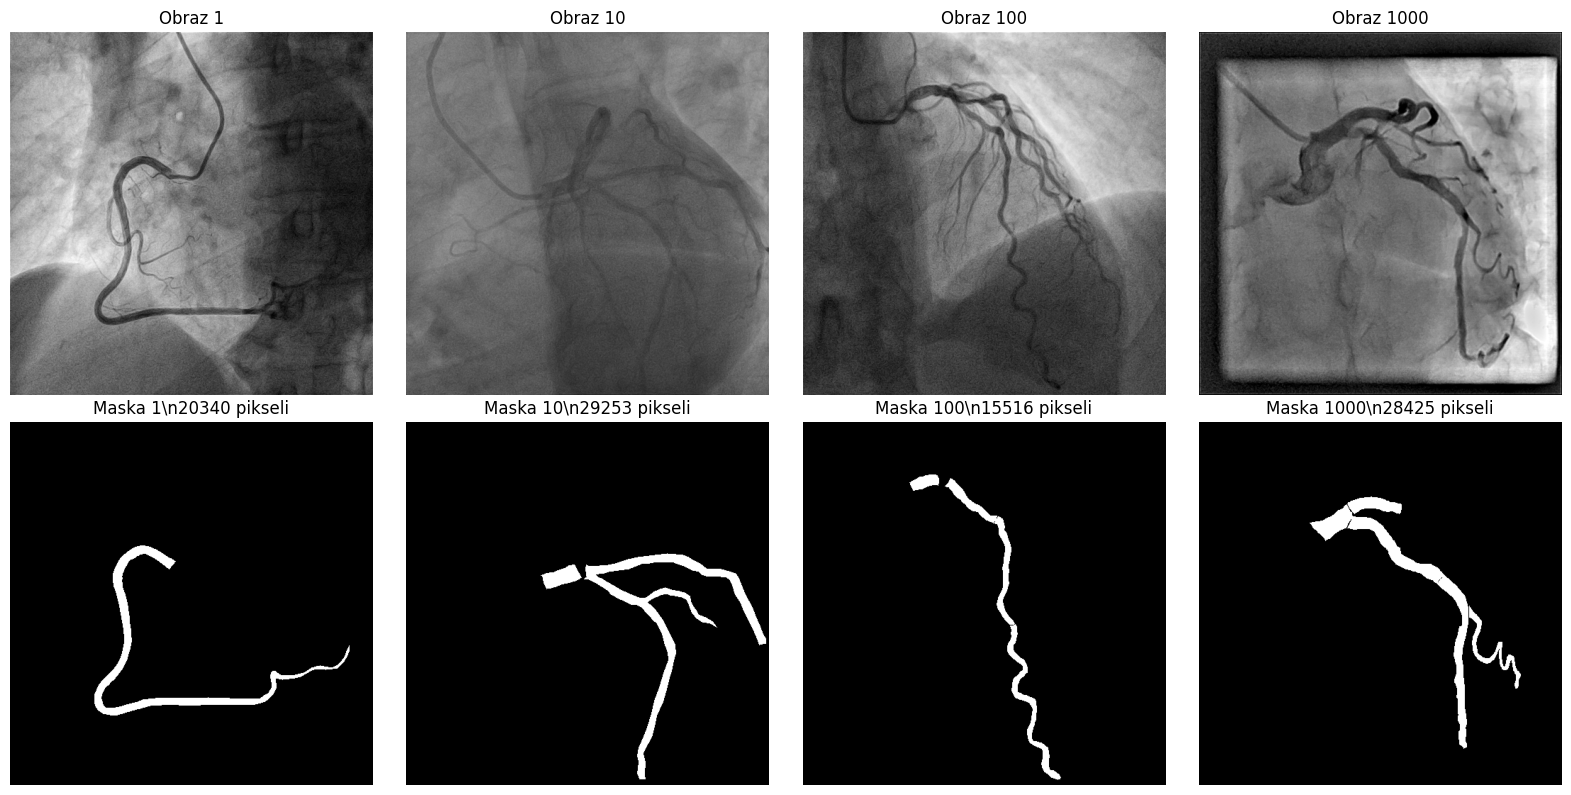

In [1]:
# 1. IMPORTY I KONFIGURACJA
import os
import glob
import torch
import numpy as np
import time
import copy
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau
# PyTorch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

# Augmentacje i preprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2

# MONAI dla zaawansowanych funkcji straty
# from monai.losses import DiceLoss as MonaiDice, FocalLoss as MonaiFocal, TverskyLoss as MonaiTversky, DiceCELoss as MonaiDiceCE, DiceFocalLoss as MonaiDiceFocal

# Sprawdzenie dostępności GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'PyTorch używa GPU: {torch.cuda.get_device_name(0)}')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("PyTorch używa MPS (Metal Performance Shaders)")
else:
    device = torch.device("cpu")
    print("GPU niedostępne, używamy CPU")

print(f"🔧 Device: {device}")
path = '/home/ives/rafal/notebooks/data'

# 2. ANALIZA DATASETU
def analyze_dataset(data_path=path):
    """Analiza struktury i właściwości datasetu"""

    imgs_path = os.path.join(data_path, "imgs")
    masks_path = os.path.join(data_path, "masks")

    # Znajdź wszystkie pliki
    img_files = sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
    mask_files = sorted(glob.glob(os.path.join(masks_path, "*.png")))

    print(f"Ścieżka danych: {data_path}")
    print(f"Znaleziono {len(img_files)} obrazów (.jpg)")
    print(f"Znaleziono {len(mask_files)} masek (.png)")

    # Sprawdź czy nazwy się zgadzają
    img_names = {os.path.splitext(os.path.basename(f))[0] for f in img_files}
    mask_names = {os.path.splitext(os.path.basename(f))[0] for f in mask_files}

    common_names = img_names.intersection(mask_names)
    print(f"{len(common_names)} par obraz-maska")

    if len(img_names - mask_names) > 0:
        print(f"{len(img_names - mask_names)} obrazów bez masek")
    if len(mask_names - img_names) > 0:
        print(f"{len(mask_names - img_names)} masek bez obrazów")

    # Analiza próbek
    print(f"\\nANALIZA PRÓBEK:")
    sample_names = sorted(list(common_names))[:5]  # Pierwsze 5 próbek

    for i, name in enumerate(sample_names):
        img_path = os.path.join(imgs_path, f"{name}.jpg")
        mask_path = os.path.join(masks_path, f"{name}.png")

        # Załaduj obraz
        img = Image.open(img_path)
        mask = Image.open(mask_path)

        # Konwertuj do numpy dla analizy
        img_np = np.array(img)
        mask_np = np.array(mask)

        print(f"\\n--- PRÓBKA {name} ---")
        print(f"Obraz: {img_np.shape}, dtype: {img_np.dtype}")
        print(f"  Min: {img_np.min()}, Max: {img_np.max()}, Mean: {img_np.mean():.2f}")

        print(f"Maska: {mask_np.shape}, dtype: {mask_np.dtype}")
        print(f"  Min: {mask_np.min()}, Max: {mask_np.max()}")
        print(f"  Unikalne wartości: {np.unique(mask_np)}")
        print(f"  Piksele pozytywne: {(mask_np > 0).sum()}/{mask_np.size} ({(mask_np > 0).mean()*100:.2f}%)")

    # Sprawdź czy obrazy są grayscale
    sample_img = Image.open(os.path.join(imgs_path, f"{sample_names[0]}.jpg"))
    sample_np = np.array(sample_img)

    is_grayscale = len(sample_np.shape) == 2 or (len(sample_np.shape) == 3 and sample_np.shape[2] == 1)
    if len(sample_np.shape) == 3 and sample_np.shape[2] == 3:
        # Sprawdź czy wszystkie kanały są identyczne (pseudo-grayscale)
        r, g, b = sample_np[:,:,0], sample_np[:,:,1], sample_np[:,:,2]
        is_grayscale = np.array_equal(r, g) and np.array_equal(g, b)

    print(f"\\nKOLORY:")
    print(f"Obrazy są grayscale: {'TAK' if is_grayscale else 'NIE'}")

    return {
        'img_files': img_files,
        'mask_files': mask_files,
        'common_names': sorted(list(common_names)),
        'is_grayscale': is_grayscale,
        'sample_shape': sample_np.shape
    }

# Uruchom analizę
dataset_info = analyze_dataset()

# 3. WIZUALIZACJA PRÓBEK
def visualize_samples(dataset_info, num_samples=4):
    """Wizualizacja próbek z datasetu"""

    data_path = path
    imgs_path = os.path.join(data_path, "imgs")
    masks_path = os.path.join(data_path, "masks")

    sample_names = dataset_info['common_names'][:num_samples]

    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*4, 8))
    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    for i, name in enumerate(sample_names):
        # Załaduj obraz i maskę
        img = Image.open(os.path.join(imgs_path, f"{name}.jpg"))
        mask = Image.open(os.path.join(masks_path, f"{name}.png"))

        # Konwertuj do numpy
        img_np = np.array(img)
        mask_np = np.array(mask)

        # Wyświetl obraz
        axes[0, i].imshow(img_np, cmap='gray' if dataset_info['is_grayscale'] else None)
        axes[0, i].set_title(f'Obraz {name}')
        axes[0, i].axis('off')

        # Wyświetl maskę
        axes[1, i].imshow(mask_np, cmap='gray')
        axes[1, i].set_title(f'Maska {name}\\n{(mask_np > 0).sum()} pikseli')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Wyświetl próbki
visualize_samples(dataset_info)



In [2]:
# 4. ARCHITEKTURY MODELI
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional

# ======================= PODSTAWOWE BLOKI =======================

class ResidualBlock(nn.Module):
    """Ulepszona wersja bloku residualnego z opcjonalnym dropout i aktywacją"""
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.0, activation='relu'):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.dropout = nn.Dropout2d(dropout) if dropout > 0 else nn.Identity()
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        # Wybór funkcji aktywacji
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'leaky_relu':
            self.activation = F.leaky_relu
        elif activation == 'elu':
            self.activation = F.elu
        else:
            self.activation = F.relu
    
    def forward(self, x):
        residual = self.shortcut(x)
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += residual
        return self.activation(out)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation block"""
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class AttentionGate(nn.Module):
    """Attention Gate dla precyzyjnego łączenia feature map"""
    def __init__(self, in_channels, gating_channels, inter_channels):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(gating_channels, inter_channels, 1, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 1, bias=True),
            nn.BatchNorm2d(inter_channels)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(inter_channels, 1, 1, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x, g):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# ======================= MODEL 0: Simple ResUNet (Baseline) =======================

class SimpleResUNet(nn.Module):
    """Stabilna wersja oryginalnego ResUNet z poprawionymi wymiarami"""
    def __init__(self, n_class=1, base_channels=64):
        super().__init__()
        # Encoder
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(base_channels, base_channels, 2)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 2, stride=2)
        
        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 2)
        
        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 2)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 2)
        
        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 2)
        
        self.final = nn.Conv2d(base_channels, n_class, 1)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        conv1 = x
        x = self.maxpool(x)
        
        conv2 = self.layer1(x)
        conv3 = self.layer2(conv2)
        conv4 = self.layer3(conv3)
        x = self.layer4(conv4)
        
        # Decoder
        x = self.up4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dec4(x)
        
        x = self.up3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec1(x)
        
        return self.final(x)

# ======================= MODEL 1: ResUNet++ (Średni) =======================

class ResUNetPlusPlus(nn.Module):
    """ResUNet++ - ulepszona wersja z nested skip connections"""
    def __init__(self, n_class=1, base_channels=64, deep_supervision=False):
        super().__init__()
        self.deep_supervision = deep_supervision
        
        # Encoder
        self.conv0_0 = self._make_layer(1, base_channels, 2)
        self.conv1_0 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.conv2_0 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        self.conv3_0 = self._make_layer(base_channels * 4, base_channels * 8, 2, stride=2)
        self.conv4_0 = self._make_layer(base_channels * 8, base_channels * 16, 2, stride=2)
        
        # Nested skip pathways
        self.conv0_1 = self._make_layer(base_channels + base_channels * 2, base_channels, 2)
        self.conv1_1 = self._make_layer(base_channels * 2 + base_channels * 4, base_channels * 2, 2)
        self.conv2_1 = self._make_layer(base_channels * 4 + base_channels * 8, base_channels * 4, 2)
        self.conv3_1 = self._make_layer(base_channels * 8 + base_channels * 16, base_channels * 8, 2)
        
        self.conv0_2 = self._make_layer(base_channels * 2 + base_channels * 2, base_channels, 2)
        self.conv1_2 = self._make_layer(base_channels * 4 + base_channels * 4, base_channels * 2, 2)
        self.conv2_2 = self._make_layer(base_channels * 8 + base_channels * 8, base_channels * 4, 2)
        
        self.conv0_3 = self._make_layer(base_channels * 3 + base_channels * 2, base_channels, 2)
        self.conv1_3 = self._make_layer(base_channels * 6 + base_channels * 4, base_channels * 2, 2)
        
        self.conv0_4 = self._make_layer(base_channels * 4 + base_channels * 2, base_channels, 2)
        
        # Upsampling layers
        self.up1_0 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        self.up2_0 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 2, stride=2)
        self.up3_0 = nn.ConvTranspose2d(base_channels * 8, base_channels * 8, 2, stride=2)
        self.up4_0 = nn.ConvTranspose2d(base_channels * 16, base_channels * 16, 2, stride=2)
        
        # Additional upsampling for nested paths
        self.up1_1 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        self.up2_1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 2, stride=2)
        self.up3_1 = nn.ConvTranspose2d(base_channels * 8, base_channels * 8, 2, stride=2)
        
        self.up1_2 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        self.up2_2 = nn.ConvTranspose2d(base_channels * 4, base_channels * 4, 2, stride=2)
        
        self.up1_3 = nn.ConvTranspose2d(base_channels * 2, base_channels * 2, 2, stride=2)
        
        # Final layers
        if deep_supervision:
            self.final1 = nn.Conv2d(base_channels, n_class, 1)
            self.final2 = nn.Conv2d(base_channels, n_class, 1)
            self.final3 = nn.Conv2d(base_channels, n_class, 1)
            self.final4 = nn.Conv2d(base_channels, n_class, 1)
        else:
            self.final = nn.Conv2d(base_channels, n_class, 1)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder path
        x0_0 = self.conv0_0(x)
        x1_0 = self.conv1_0(x0_0)
        x2_0 = self.conv2_0(x1_0)
        x3_0 = self.conv3_0(x2_0)
        x4_0 = self.conv4_0(x3_0)
        
        # Nested skip connections - Level 1
        x0_1 = self.conv0_1(torch.cat([x0_0, self.up1_0(x1_0)], 1))
        x1_1 = self.conv1_1(torch.cat([x1_0, self.up2_0(x2_0)], 1))
        x2_1 = self.conv2_1(torch.cat([x2_0, self.up3_0(x3_0)], 1))
        x3_1 = self.conv3_1(torch.cat([x3_0, self.up4_0(x4_0)], 1))
        
        # Nested skip connections - Level 2
        x0_2 = self.conv0_2(torch.cat([x0_0, x0_1, self.up1_1(x1_1)], 1))
        x1_2 = self.conv1_2(torch.cat([x1_0, x1_1, self.up2_1(x2_1)], 1))
        x2_2 = self.conv2_2(torch.cat([x2_0, x2_1, self.up3_1(x3_1)], 1))
        
        # Nested skip connections - Level 3
        x0_3 = self.conv0_3(torch.cat([x0_0, x0_1, x0_2, self.up1_2(x1_2)], 1))
        x1_3 = self.conv1_3(torch.cat([x1_0, x1_1, x1_2, self.up2_2(x2_2)], 1))
        
        # Final level
        x0_4 = self.conv0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.up1_3(x1_3)], 1))
        
        if self.deep_supervision:
            output1 = self.final1(x0_1)
            output2 = self.final2(x0_2)
            output3 = self.final3(x0_3)
            output4 = self.final4(x0_4)
            return [output1, output2, output3, output4]
        else:
            return self.final(x0_4)

# ======================= MODEL 2: Attention ResUNet (Duży) =======================

class AttentionResUNet(nn.Module):
    """ResUNet z Attention Gates i SE blocks"""
    def __init__(self, n_class=1, base_channels=64, use_se=True, dropout_p=0.1):
        super().__init__()
        self.use_se = use_se
        
        # Encoder - POPRAWIONE WYMIARY
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(base_channels, base_channels, 3)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 4, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 6, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 3, stride=2)
        
        # SE blocks
        if use_se:
            self.se1 = SEBlock(base_channels)
            self.se2 = SEBlock(base_channels * 2)
            self.se3 = SEBlock(base_channels * 4)
            self.se4 = SEBlock(base_channels * 8)
        
        # Attention Gates - POPRAWIONE WYMIARY
        self.att4 = AttentionGate(base_channels * 4, base_channels * 4, base_channels * 2)
        self.att3 = AttentionGate(base_channels * 2, base_channels * 2, base_channels)
        self.att2 = AttentionGate(base_channels, base_channels, base_channels // 2)
        self.att1 = AttentionGate(base_channels, base_channels, base_channels // 2)
        
        # Decoder - POPRAWIONE WYMIARY
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 3)
        
        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 3)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 3)
        
        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 2)
        
        self.final = nn.Conv2d(base_channels, n_class, 1)
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride, dropout=0.1)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout=0.1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        conv1 = x
        x = self.maxpool(x)
        
        conv2 = self.layer1(x)
        if self.use_se: conv2 = self.se1(conv2)
        
        conv3 = self.layer2(conv2)
        if self.use_se: conv3 = self.se2(conv3)
        
        conv4 = self.layer3(conv3)
        if self.use_se: conv4 = self.se3(conv4)
        
        x = self.layer4(conv4)
        if self.use_se: x = self.se4(x)
        
        # Decoder with attention - POPRAWIONE
        x = self.up4(x)
        conv4_att = self.att4(conv4, x)
        x = torch.cat([x, conv4_att], dim=1)
        x = self.dec4(x)
        
        x = self.up3(x)
        conv3_att = self.att3(conv3, x)
        x = torch.cat([x, conv3_att], dim=1)
        x = self.dec3(x)
        
        x = self.up2(x)
        conv2_att = self.att2(conv2, x)
        x = torch.cat([x, conv2_att], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)
        conv1_att = self.att1(conv1, x)
        x = torch.cat([x, conv1_att], dim=1)
        x = self.dec1(x)
        
        return self.final(x)

# ======================= MODEL 3: Deep ResUNet (Bardzo duży) =======================

class DeepResUNet(nn.Module):
    """Bardzo głęboki ResUNet inspirowany ResNet-152"""
    def __init__(self, n_class=1, base_channels=64, layers=[3, 8, 36, 3]):
        super().__init__()
        
        # Initial conv - BEZ stride=2, żeby zachować wymiary
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Encoder layers
        self.layer1 = self._make_layer(base_channels, base_channels, layers[0])
        self.layer2 = self._make_layer(base_channels, base_channels * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, layers[3], stride=2)
        
        # Bridge with dilated convolutions
        self.bridge = nn.Sequential(
            nn.Conv2d(base_channels * 8, base_channels * 16, 3, padding=2, dilation=2),
            nn.BatchNorm2d(base_channels * 16),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 16, base_channels * 16, 3, padding=4, dilation=4),
            nn.BatchNorm2d(base_channels * 16),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels * 16, base_channels * 8, 3, padding=2, dilation=2),
            nn.BatchNorm2d(base_channels * 8),
            nn.ReLU(inplace=True)
        )
        
        # Decoder with more layers
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 6)
        
        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 8)
        
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 4)
        
        # POPRAWIONE - upsampling do oryginalnego rozmiaru
        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 3)
        
        # Final conv bez dodatkowego upsamplingu
        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels // 2, 3, padding=1),
            nn.BatchNorm2d(base_channels // 2),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels // 2, n_class, 1)
        )
    
    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock(in_channels, out_channels, stride, dropout=0.1, activation='leaky_relu')]
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, dropout=0.1, activation='leaky_relu'))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Encoder - zapisujemy feature mapy dla skip connections
        original_size = x.shape[2:]  # Zapisz oryginalny rozmiar
        
        x = F.relu(self.bn1(self.conv1(x)))
        conv0 = x  # 512x512
        x = self.maxpool(x)
        
        conv1 = self.layer1(x)  # 256x256
        conv2 = self.layer2(conv1)  # 128x128  
        conv3 = self.layer3(conv2)  # 64x64
        conv4 = self.layer4(conv3)  # 32x32
        
        # Bridge
        x = self.bridge(conv4)  # 32x32
        
        # Decoder z prawidłowymi wymiarami
        x = self.up4(x)  # 64x64
        x = torch.cat([x, conv3], dim=1)
        x = self.dec4(x)
        
        x = self.up3(x)  # 128x128
        x = torch.cat([x, conv2], dim=1) 
        x = self.dec3(x)
        
        x = self.up2(x)  # 256x256
        x = torch.cat([x, conv1], dim=1)
        x = self.dec2(x)
        
        x = self.up1(x)  # 512x512
        x = torch.cat([x, conv0], dim=1)
        x = self.dec1(x)
        
        return self.final_conv(x)

# ======================= FUNKCJE POMOCNICZE =======================

def count_parameters(model):
    """Liczy parametry modelu"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_info(model, input_size=(1, 1, 512, 512)):
    """Zwraca informacje o modelu"""
    total_params = count_parameters(model)
    
    # Test forward pass
    model.eval()
    with torch.no_grad():
        x = torch.randn(input_size)
        try:
            output = model(x)
            if isinstance(output, list):
                output_shape = [o.shape for o in output]
            else:
                output_shape = output.shape
        except Exception as e:
            output_shape = f"Error: {e}"
    
    return {
        'parameters': total_params,
        'parameters_M': total_params / 1e6,
        'output_shape': output_shape
    }

# def create_model(model_type='resunet++', **kwargs):
#     """Factory function do tworzenia modeli"""
#     models = {
#         'resunet++': ResUNetPlusPlus,
#         'attention_resunet': AttentionResUNet,
#         'deep_resunet': DeepResUNet
#     }
    
#     if model_type not in models:
#         raise ValueError(f"Unknown model type: {model_type}. Available: {list(models.keys())}")
    
#     return models[model_type](**kwargs)

# # ======================= PRZYKŁADY UŻYCIA =======================

# if __name__ == "__main__":
#     print("🏗️  PORÓWNANIE MODELI ResUNet")
#     print("=" * 50)
    
#     models_config = [
#         ('Original ResUNet (baseline)', 'simple_resunet', {'base_channels': 64}),
#         ('ResUNet++', 'resunet++', {'base_channels': 64}),
#         ('Attention ResUNet', 'attention_resunet', {'base_channels': 64}),
#         ('Deep ResUNet', 'deep_resunet', {'base_channels': 64}),
#         ('Large Deep ResUNet', 'deep_resunet', {'base_channels': 96, 'layers': [3, 12, 48, 3]}),
#     ]
    
#     for name, model_type, config in models_config:
#         try:
#             model = create_model(model_type, **config)
#             info = get_model_info(model)
            
#             print(f"\n📊 {name}:")
#             print(f"   Parameters: {info['parameters_M']:.2f}M ({info['parameters']:,})")
#             print(f"   Output shape: {info['output_shape']}")
            
#         except Exception as e:
#             print(f"\n❌ {name}: Error - {e}")
    
#     print("\n" + "=" * 50)
#     print("💡 Wszystkie modele gotowe do użycia!")

def double_conv(in_channels, out_channels):
    """Standardowy blok podwójnej konwolucji"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

def enhanced_double_conv(in_channels, out_channels, dropout_p=0.1):
    """Rozszerzony blok z batch normalization i dropout"""
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(dropout_p),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(dropout_p)
    )

# Original UNet
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder
        self.dconv_down1 = double_conv(1, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

# Enhanced UNet z większą liczbą parametrów
class EnhancedUNet(nn.Module):
    def __init__(self, n_class=1, dropout_p=0.1, base_channels=64):
        super().__init__()

        # Encoder (5 poziomów)
        self.dconv_down1 = enhanced_double_conv(1, base_channels, dropout_p)
        self.dconv_down2 = enhanced_double_conv(base_channels, base_channels * 2, dropout_p)
        self.dconv_down3 = enhanced_double_conv(base_channels * 2, base_channels * 4, dropout_p)
        self.dconv_down4 = enhanced_double_conv(base_channels * 4, base_channels * 8, dropout_p)
        self.dconv_down5 = enhanced_double_conv(base_channels * 8, base_channels * 16, dropout_p)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Decoder
        self.dconv_up4 = enhanced_double_conv(base_channels * 8 + base_channels * 16, base_channels * 8, dropout_p)
        self.dconv_up3 = enhanced_double_conv(base_channels * 4 + base_channels * 8, base_channels * 4, dropout_p)
        self.dconv_up2 = enhanced_double_conv(base_channels * 2 + base_channels * 4, base_channels * 2, dropout_p)
        self.dconv_up1 = enhanced_double_conv(base_channels + base_channels * 2, base_channels, dropout_p)

        self.conv_last = nn.Conv2d(base_channels, n_class, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out

# Residual blocks dla ResUNet
class ResidualBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class ResUNet(nn.Module):
    def __init__(self, n_class=1, base_channels=64):
        super().__init__()

        # Encoder
        self.conv1 = nn.Conv2d(1, base_channels, 7, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.layer1 = self._make_layer(base_channels, base_channels, 2)
        self.layer2 = self._make_layer(base_channels, base_channels * 2, 2, stride=2)
        self.layer3 = self._make_layer(base_channels * 2, base_channels * 4, 2, stride=2)
        self.layer4 = self._make_layer(base_channels * 4, base_channels * 8, 2, stride=2)

        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels * 8, base_channels * 4, 2, stride=2)
        self.dec4 = self._make_layer(base_channels * 8, base_channels * 4, 2)

        self.up3 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.dec3 = self._make_layer(base_channels * 4, base_channels * 2, 2)

        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        self.dec2 = self._make_layer(base_channels * 2, base_channels, 2)

        self.up1 = nn.ConvTranspose2d(base_channels, base_channels, 2, stride=2)
        self.dec1 = self._make_layer(base_channels * 2, base_channels, 2)

        self.final = nn.Conv2d(base_channels, n_class, 1)

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        layers = [ResidualBlock2(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResidualBlock2(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        x = F.relu(self.bn1(self.conv1(x)))
        conv1 = x
        x = self.maxpool(x)

        conv2 = self.layer1(x)
        conv3 = self.layer2(conv2)
        conv4 = self.layer3(conv3)
        x = self.layer4(conv4)

        # Decoder
        x = self.up4(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dec4(x)

        x = self.up3(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dec1(x)

        return self.final(x)

# Funkcja do tworzenia modeli
def create_model(model_type='unet', n_class=1):
    """Factory function dla tworzenia modeli"""
    if model_type == 'unet':
        return UNet(n_class)
    elif model_type == 'enhanced_unet':
        return EnhancedUNet(n_class, dropout_p=0.1, base_channels=64)
    elif model_type == 'resunet' or model_type == 'ResUNet':
        return ResUNet(n_class, base_channels=64)
    elif model_type == 'resunetpp':
        return ResUNetPlusPlus(n_class)
    elif model_type == 'attention_resunet':
        return AttentionResUNet(n_class, dropout_p=0.1, base_channels=64)
    elif model_type == 'deep_resunet':
        return DeepResUNet(n_class, base_channels=64)
    else:
        raise ValueError(f"Nieznany typ modelu: {model_type}")

# Porównanie liczby parametrów
def compare_model_sizes():
    """Porównanie rozmiarów modeli"""
    models = {
        'UNet': UNet(1),
        'Enhanced UNet': EnhancedUNet(1),
        'ResUNet': ResUNet(1),
        'ResUNetPP': ResUNetPlusPlus(1),
        'AttentionResUNet': AttentionResUNet(1),
        'DeepResUNet': DeepResUNet(1)
    }

    print("📊 PORÓWNANIE MODELI:")
    print("-" * 40)

    for name, model in models.items():
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"{name:15}: {total_params:,} parametrów ({trainable_params:,} trenowalnych)")

    return models

# Porównaj modele
model_comparison = compare_model_sizes()


📊 PORÓWNANIE MODELI:
----------------------------------------
UNet           : 7,781,761 parametrów (7,781,761 trenowalnych)
Enhanced UNet  : 31,389,569 parametrów (31,389,569 trenowalnych)
ResUNet        : 16,115,713 parametrów (16,115,713 trenowalnych)
ResUNetPP      : 79,597,121 parametrów (79,597,121 trenowalnych)
AttentionResUNet: 27,909,389 parametrów (27,909,389 trenowalnych)
DeepResUNet    : 88,443,457 parametrów (88,443,457 trenowalnych)


In [3]:
# # 6. FUNKCJE STRATY

# from abc import ABC, abstractmethod

# class LossFunction(ABC):
#     @abstractmethod
#     def compute(self, pred, target):
#         pass

# # Podstawowe funkcje straty
# class DiceLoss(LossFunction):
#     def compute(self, pred, target, smooth=1e-5):
#         pred = pred.contiguous()
#         target = target.contiguous()
#         intersection = (pred * target).sum(dim=2).sum(dim=2)
#         loss = (1 - ((2. * intersection + smooth) /
#                     (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
#         return loss.mean()

# class IoULoss(LossFunction):
#     def compute(self, pred, target, smooth=1e-5):
#         intersection = (pred * target).sum()
#         union = pred.sum() + target.sum() - intersection
#         iou = (intersection + smooth) / (union + smooth)
#         return 1 - iou

# # MONAI Loss Functions - POPRAWIONE
# class MonaiDiceLoss(LossFunction):
#     def __init__(self, include_background=False, sigmoid=True, smooth_nr=1e-5, smooth_dr=1e-5):
#         # include_background=False dla segmentacji tętnic (foreground)
#         self.dice_loss = MonaiDice(
#             include_background=include_background,
#             sigmoid=sigmoid,
#             smooth_nr=smooth_nr,
#             smooth_dr=smooth_dr
#         )

#     def compute(self, pred, target):
#         # Sprawdź czy maski mają pozytywne piksele
#         if target.sum() == 0:
#             print("WARNING: Wszystkie maski są zerowe!")
#             return torch.tensor(1.0, device=pred.device)
#         return self.dice_loss(pred, target)

# class MonaiFocalLoss(LossFunction):
#     def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
#         self.focal_loss = MonaiFocal(alpha=alpha, gamma=gamma, reduction=reduction)

#     def compute(self, pred, target):
#         return self.focal_loss(pred, target)

# class MonaiTverskyLoss(LossFunction):
#     def __init__(self, alpha=0.5, beta=0.5, sigmoid=True):
#         self.tversky_loss = MonaiTversky(alpha=alpha, beta=beta, sigmoid=sigmoid)

#     def compute(self, pred, target):
#         return self.tversky_loss(pred, target)

# class MonaiDiceCELoss(LossFunction):
#     def __init__(self, sigmoid=True, lambda_dice=1.0, lambda_ce=1.0):
#         self.dice_ce_loss = MonaiDiceCE(sigmoid=sigmoid, lambda_dice=lambda_dice, lambda_ce=lambda_ce)

#     def compute(self, pred, target):
#         return self.dice_ce_loss(pred, target)

# class MonaiDiceFocalLoss(LossFunction):
#     def __init__(self, sigmoid=True, lambda_dice=1.0, lambda_focal=1.0, alpha=0.25, gamma=2.0):
#         self.dice_focal_loss = MonaiDiceFocal(
#             sigmoid=sigmoid,
#             lambda_dice=lambda_dice,
#             lambda_focal=lambda_focal,
#             alpha=alpha,
#             gamma=gamma
#         )

#     def compute(self, pred, target):
#         return self.dice_focal_loss(pred, target)

# class CombinedLoss(LossFunction):
#     def __init__(self, loss_functions_weights):
#         """
#         loss_functions_weights: dict of {loss_function_instance: weight}
#         """
#         self.loss_functions_weights = loss_functions_weights

#     def compute(self, pred, target):
#         total_loss = 0
#         for loss_fn, weight in self.loss_functions_weights.items():
#             total_loss += weight * loss_fn.compute(pred, target)
#         return total_loss

# # Funkcja do obliczania łącznej straty
# def calculate_loss(pred, target, metrics, bce_weight=0.1, loss_function=None):
#     """Oblicza łączną stratę BCE + funkcja straty"""

#     if loss_function is None:
#         loss_function = DiceLoss()

#     # BCE Loss
#     bce = F.binary_cross_entropy_with_logits(pred, target)

#     # Zastosuj sigmoid dla funkcji straty
#     pred_sigmoid = torch.sigmoid(pred)

#     # Oblicz stratę z wybranej funkcji
#     custom_loss = loss_function.compute(pred_sigmoid, target)

#     # Łączna strata
#     total_loss = bce * bce_weight + custom_loss * (1 - bce_weight)

#     # Aktualizuj metryki
#     loss_name = loss_function.__class__.__name__.lower().replace('loss', '')
#     with torch.no_grad():
#         metrics['bce'] += bce.item() * target.size(0)
#         metrics[loss_name] += custom_loss.item() * target.size(0)
#         metrics['total_loss'] += total_loss.item() * target.size(0)

#     return total_loss

# # Dostępne funkcje straty
# def get_loss_functions():
#     """Zwraca mapowanie dostępnych funkcji straty"""
#     return {
#         'dice': DiceLoss(),
#         'iou': IoULoss(),
#         'monai_dice': MonaiDiceLoss(include_background=False, sigmoid=True),
#         'monai_focal': MonaiFocalLoss(),
#         'monai_tversky': MonaiTverskyLoss(),
#         'monai_dice_ce': MonaiDiceCELoss(),
#         'monai_dice_focal': MonaiDiceFocalLoss(),
#         'combined': CombinedLoss({
#             MonaiDiceLoss(include_background=False): 0.6,
#             MonaiFocalLoss(): 0.4
#         })
#     }

# # Wyświetl dostępne funkcje straty
# print("DOSTĘPNE FUNKCJE STRATY:")
# loss_functions = get_loss_functions()
# for name, loss_fn in loss_functions.items():
#     print(f"  - '{name}': {loss_fn.__class__.__name__}")

# # Test funkcji straty na przykładowych danych
# def test_loss_functions():
#     """Test wszystkich funkcji straty"""
#     print("\\nTEST FUNKCJI STRATY:")

#     # Stwórz przykładowe dane
#     batch_size = 2
#     pred = torch.randn(batch_size, 1, 64, 64, device=device)
#     target = torch.randint(0, 2, (batch_size, 1, 64, 64), device=device).float()

#     print(f"Test data - Pred: {pred.shape}, Target: {target.shape}")
#     print(f"Target positive pixels: {target.sum().item()}")

#     for name, loss_fn in loss_functions.items():
#         try:
#             pred_sigmoid = torch.sigmoid(pred)
#             loss_value = loss_fn.compute(pred_sigmoid, target)
#             print(f"  {name:15}: {loss_value:.6f}")
#         except Exception as e:
#             print(f"  {name:15}: ERROR - {str(e)}")

# test_loss_functions()

# 6. FUNKCJE STRATY - IMPLEMENTACJA BEZ MONAI

import torch
import torch.nn as nn
import torch.nn.functional as F
from abc import ABC, abstractmethod

class LossFunction(ABC):
    @abstractmethod
    def compute(self, pred, target):
        pass

# Podstawowe funkcje straty
class DiceLoss(LossFunction):
    def __init__(self, smooth=1e-5):
        self.smooth = smooth
    
    def compute(self, pred, target):
        pred = pred.contiguous()
        target = target.contiguous()
        intersection = (pred * target).sum(dim=2).sum(dim=2)
        loss = (1 - ((2. * intersection + self.smooth) /
                    (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + self.smooth)))
        return loss.mean()

class IoULoss(LossFunction):
    def __init__(self, smooth=1e-5):
        self.smooth = smooth
    
    def compute(self, pred, target):
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)
        return 1 - iou

# Manualne implementacje funkcji straty (bez MONAI)
class FocalLoss(LossFunction):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def compute(self, pred, target):
        """
        Focal Loss dla segmentacji binarnej
        pred: (N, C, H, W) - logits lub prawdopodobieństwa
        target: (N, C, H, W) - binarne maski
        """
        # Sprawdź czy pred to prawdopodobieństwa czy logits
        if pred.min() < 0 or pred.max() > 1:
            # Jeśli to logits, zastosuj sigmoid
            pred = torch.sigmoid(pred)
        
        # Oblicz BCE dla każdego piksela
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        
        # p_t - prawdopodobieństwo dla prawidłowej klasy
        p_t = pred * target + (1 - pred) * (1 - target)
        
        # alpha_t - waga dla prawidłowej klasy
        alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
        
        # Focal Loss
        focal_loss = alpha_t * (1 - p_t) ** self.gamma * bce
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class TverskyLoss(LossFunction):
    def __init__(self, alpha=0.5, beta=0.5, smooth=1e-5):
        """
        Tversky Loss
        alpha: waga dla False Positives
        beta: waga dla False Negatives
        Gdy alpha=beta=0.5, odpowiada Dice Loss
        """
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    
    def compute(self, pred, target):
        # Sprawdź czy pred to prawdopodobieństwa czy logits
        if pred.min() < 0 or pred.max() > 1:
            pred = torch.sigmoid(pred)
        
        # Flatten tensors
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        # True Positives, False Positives, False Negatives
        TP = (pred_flat * target_flat).sum()
        FP = ((1 - target_flat) * pred_flat).sum()
        FN = (target_flat * (1 - pred_flat)).sum()
        
        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        
        return 1 - tversky

class DiceCELoss(LossFunction):
    def __init__(self, lambda_dice=1.0, lambda_ce=1.0, smooth=1e-5):
        """
        Kombinacja Dice Loss + Cross Entropy Loss
        """
        self.lambda_dice = lambda_dice
        self.lambda_ce = lambda_ce
        self.dice_loss = DiceLoss(smooth=smooth)
    
    def compute(self, pred, target):
        # Dice Loss (wymaga prawdopodobieństw)
        if pred.min() < 0 or pred.max() > 1:
            pred_prob = torch.sigmoid(pred)
            dice_loss = self.dice_loss.compute(pred_prob, target)
            # CE Loss (wymaga logits)
            ce_loss = F.binary_cross_entropy_with_logits(pred, target)
        else:
            # pred to już prawdopodobieństwa
            dice_loss = self.dice_loss.compute(pred, target)
            # Konwertuj do logits dla CE
            pred_logits = torch.log(pred / (1 - pred + 1e-8))
            ce_loss = F.binary_cross_entropy_with_logits(pred_logits, target)
        
        return self.lambda_dice * dice_loss + self.lambda_ce * ce_loss

class DiceFocalLoss(LossFunction):
    def __init__(self, lambda_dice=1.0, lambda_focal=1.0, alpha=0.25, gamma=2.0, smooth=1e-5):
        """
        Kombinacja Dice Loss + Focal Loss
        """
        self.lambda_dice = lambda_dice
        self.lambda_focal = lambda_focal
        self.dice_loss = DiceLoss(smooth=smooth)
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
    
    def compute(self, pred, target):
        # Sprawdź czy pred to prawdopodobieństwa czy logits
        if pred.min() < 0 or pred.max() > 1:
            pred_prob = torch.sigmoid(pred)
        else:
            pred_prob = pred
        
        dice_loss = self.dice_loss.compute(pred_prob, target)
        focal_loss = self.focal_loss.compute(pred_prob, target)
        
        return self.lambda_dice * dice_loss + self.lambda_focal * focal_loss

class CombinedLoss(LossFunction):
    def __init__(self, loss_functions_weights):
        """
        loss_functions_weights: dict of {loss_function_instance: weight}
        """
        self.loss_functions_weights = loss_functions_weights

    def compute(self, pred, target):
        total_loss = 0
        for loss_fn, weight in self.loss_functions_weights.items():
            total_loss += weight * loss_fn.compute(pred, target)
        return total_loss

# Dodatkowe funkcje straty
class LogCoshDiceLoss(LossFunction):
    def __init__(self, smooth=1e-5):
        """
        Log-Cosh Dice Loss - łagodniejsza wersja Dice Loss
        """
        self.smooth = smooth
    
    def compute(self, pred, target):
        if pred.min() < 0 or pred.max() > 1:
            pred = torch.sigmoid(pred)
        
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        
        return torch.log(torch.cosh(1 - dice))

class ComboLoss(LossFunction):
    def __init__(self, alpha=0.5, ce_ratio=0.5, smooth=1e-5):
        """
        Combo Loss = alpha * BCE + (1-alpha) * Dice
        """
        self.alpha = alpha
        self.ce_ratio = ce_ratio
        self.smooth = smooth
    
    def compute(self, pred, target):
        # BCE component
        if pred.min() < 0 or pred.max() > 1:
            bce = F.binary_cross_entropy_with_logits(pred, target)
            pred_prob = torch.sigmoid(pred)
        else:
            bce = F.binary_cross_entropy(pred, target)
            pred_prob = pred
        
        # Dice component
        pred_flat = pred_prob.view(-1)
        target_flat = target.view(-1)
        
        intersection = (pred_flat * target_flat).sum()
        dice = (2. * intersection + self.smooth) / (pred_flat.sum() + target_flat.sum() + self.smooth)
        dice_loss = 1 - dice
        
        return self.alpha * bce + (1 - self.alpha) * dice_loss

# Funkcja do obliczania łącznej straty
def calculate_loss(pred, target, metrics, bce_weight=0.3, loss_function=None):
    """Oblicza łączną stratę BCE + funkcja straty"""

    if loss_function is None:
        loss_function = DiceLoss()

    # BCE Loss
    bce = F.binary_cross_entropy_with_logits(pred, target)

    # Zastosuj sigmoid dla funkcji straty
    pred_sigmoid = torch.sigmoid(pred)

    # Oblicz stratę z wybranej funkcji
    custom_loss = loss_function.compute(pred_sigmoid, target)

    # Łączna strata
    total_loss = bce * bce_weight + custom_loss * (1 - bce_weight)

    # Aktualizuj metryki
    loss_name = loss_function.__class__.__name__.lower().replace('loss', '')
    with torch.no_grad():
        metrics['bce'] += bce.item() * target.size(0)
        metrics[loss_name] += custom_loss.item() * target.size(0)
        metrics['total_loss'] += total_loss.item() * target.size(0)

    return total_loss

# Dostępne funkcje straty
def get_loss_functions():
    """Zwraca mapowanie dostępnych funkcji straty"""
    return {
        'dice': DiceLoss(),
        'iou': IoULoss(),
        'focal': FocalLoss(),
        'tversky': TverskyLoss(),
        'dice_ce': DiceCELoss(),
        'dice_focal': DiceFocalLoss(),
        'log_cosh_dice': LogCoshDiceLoss(),
        'combo': ComboLoss(),
        'combined': CombinedLoss({
            DiceLoss(): 0.6,
            FocalLoss(): 0.4
        })
    }

# Test funkcji straty na przykładowych danych
def test_loss_functions(device='cpu'):
    """Test wszystkich funkcji straty"""
    print("\nTEST FUNKCJI STRATY:")
    
    # Wyświetl dostępne funkcje straty
    print("\nDOSTĘPNE FUNKCJE STRATY:")
    loss_functions = get_loss_functions()
    for name, loss_fn in loss_functions.items():
        print(f"  - '{name}': {loss_fn.__class__.__name__}")

    # Stwórz przykładowe dane
    batch_size = 2
    pred = torch.randn(batch_size, 1, 64, 64, device=device)
    target = torch.randint(0, 2, (batch_size, 1, 64, 64), device=device).float()

    print(f"\nTest data - Pred: {pred.shape}, Target: {target.shape}")
    print(f"Target positive pixels: {target.sum().item()}")
    print(f"Pred range: [{pred.min():.3f}, {pred.max():.3f}]")

    print("\nWYNIKI TESTÓW:")
    for name, loss_fn in loss_functions.items():
        try:
            # Test z logits (surowe wyjście sieci)
            loss_value_logits = loss_fn.compute(pred, target)
            
            # Test z prawdopodobieństwami
            pred_sigmoid = torch.sigmoid(pred)
            loss_value_prob = loss_fn.compute(pred_sigmoid, target)
            
            print(f"  {name:15}: logits={loss_value_logits:.6f}, prob={loss_value_prob:.6f}")
        except Exception as e:
            print(f"  {name:15}: ERROR - {str(e)}")

# Uruchom test jeśli plik jest wykonywany bezpośrednio

    
test_loss_functions(device)



TEST FUNKCJI STRATY:

DOSTĘPNE FUNKCJE STRATY:
  - 'dice': DiceLoss
  - 'iou': IoULoss
  - 'focal': FocalLoss
  - 'tversky': TverskyLoss
  - 'dice_ce': DiceCELoss
  - 'dice_focal': DiceFocalLoss
  - 'log_cosh_dice': LogCoshDiceLoss
  - 'combo': ComboLoss
  - 'combined': CombinedLoss

Test data - Pred: torch.Size([2, 1, 64, 64]), Target: torch.Size([2, 1, 64, 64])
Target positive pixels: 4088.0
Pred range: [-4.528, 3.462]

WYNIKI TESTÓW:
  dice           : logits=0.977353, prob=0.497361
  iou            : logits=0.988512, prob=0.664307
  focal          : logits=0.168270, prob=0.168270
  tversky        : logits=0.497350, prob=0.497350
  dice_ce        : logits=1.293826, prob=1.293826
  dice_focal     : logits=0.665631, prob=0.665631
  log_cosh_dice  : logits=0.118893, prob=0.118893
  combo          : logits=0.646907, prob=0.646907
  combined       : logits=0.653720, prob=0.365725


In [4]:
# 7. TRENING MODELU

def print_metrics(metrics, epoch_samples, phase):
    """Wydrukuj metryki"""
    outputs = [f"{k}: {metrics[k] / epoch_samples:.4f}" for k in metrics.keys()]
    print(f"{phase}: {', '.join(outputs)}")


def train_model(model, dataloaders, optimizer, scheduler, loss_function_name='dice',
                bce_weight=0.1, num_epochs=10, save_path='best_model.pth'):
    """
    Główna funkcja treningu modelu
    """

    model = model.to(device)

    # Pobierz funkcję straty
    loss_functions = get_loss_functions()
    if loss_function_name not in loss_functions:
        print(f"Nieznana funkcja straty: {loss_function_name}, używam 'dice'")
        loss_function_name = 'dice'

    loss_function = loss_functions[loss_function_name]
    print(f"🎯 Funkcja straty: {loss_function_name}")

    writer = SummaryWriter(comment=f'_{loss_function_name}_epochs_{num_epochs}_bce_{bce_weight}')

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    history = {'train_loss': [], 'val_loss': []}

    print(f"🚀 Rozpoczynam trening na {num_epochs} epok...")
    print(f"📱 TensorBoard: tensorboard --logdir=runs")

    for epoch in range(num_epochs):
        print(f'\n🔄 Epoka {epoch+1}/{num_epochs}')
        print('-' * 50)

        since = time.time()
        val_epoch_loss = None  # Dodane na potrzeby ReduceLROnPlateau

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                print(f"📚 Trening - LR: {optimizer.param_groups[0]['lr']:.6f}")
            else:
                model.eval()
                print(f"🔍 Walidacja")

            running_metrics = defaultdict(float)
            epoch_samples = 0

            dataloader = dataloaders[phase]
            progress_bar = tqdm(dataloader, desc=f'{phase} Epoch {epoch+1}')

            for batch_idx, (inputs, labels) in enumerate(progress_bar):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calculate_loss(outputs, labels, running_metrics,
                                          bce_weight, loss_function)

                    if phase == 'train':
                        loss.backward()
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                        optimizer.step()

                epoch_samples += inputs.size(0)

                current_loss = running_metrics['total_loss'] / epoch_samples
                progress_bar.set_postfix({'loss': f'{current_loss:.4f}'})

                if batch_idx % 50 == 0:
                    global_step = epoch * len(dataloader) + batch_idx
                    writer.add_scalar(f'Batch_Loss/{phase}', loss.item(), global_step)

            epoch_loss = running_metrics['total_loss'] / epoch_samples
            epoch_bce = running_metrics['bce'] / epoch_samples
            custom_loss_name = list(running_metrics.keys())[1]
            epoch_custom = running_metrics[custom_loss_name] / epoch_samples

            print_metrics(running_metrics, epoch_samples, phase)

            writer.add_scalar(f'Epoch_Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'BCE/{phase}', epoch_bce, epoch)
            writer.add_scalar(f'{loss_function_name}/{phase}', epoch_custom, epoch)

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
            else:
                history['val_loss'].append(epoch_loss)
                val_epoch_loss = epoch_loss  # 🔧 potrzebne do ReduceLROnPlateau

                if epoch_loss < best_loss:
                    print(f"💾 Zapisuję najlepszy model (val_loss: {epoch_loss:.4f})")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': best_loss,
                        'model_type': model.__class__.__name__
                    }, save_path)

        # 🔁 Scheduler krok
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            if val_epoch_loss is not None:
                scheduler.step(val_epoch_loss)
                print("Scheduler with val_epoch_loss: {val_epoch_loss}")
            else:
                print("Brak val_epoch_loss – nie można wywołać ReduceLROnPlateau.step()")
        else:
            scheduler.step()

        time_elapsed = time.time() - since
        print(f'⏱️ Czas epoki: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

    print(f'\n🎉 Trening zakończony!')
    print(f'📊 Najlepszy val_loss: {best_loss:.4f}')

    model.load_state_dict(best_model_wts)
    writer.close()

    return model, history


def setup_training(model_type='unet', lr=0.005, batch_size=16, optimizer_type='adam'):
    """Skonfiguruj model, optimizer i scheduler"""

    # Stwórz model
    model = create_model(model_type)
    print(f"Model: {model.__class__.__name__}")

    # Optimizer
    if optimizer_type == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    elif optimizer_type == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
    elif optimizer_type == 'adamw':
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    else:
        raise ValueError(f"Nieznany optimizer: {optimizer_type}")

    # Scheduler
    # scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.7,          # mniej agresywne (było 0.5)
    patience=5,          # więcej cierpliwości (było 3)
    threshold=0.005,     # wyższa tolerancja
    min_lr=1e-6
)
    # Załóżmy, że używasz optymalizatora Adam
    """
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',          # Monitorujemy metrykę (np. Dice Score), więc 'max'
        factor=0.1,          # Zmniejsz LR 10-krotnie
        patience=10,         # Czekaj 10 epok bez poprawy
        threshold=0.0001,    # Wymagaj co najmniej 0.0001 poprawy
        min_lr=1e-7,         # Minimalny LR
    )"""
    # Dataloaders
    dataloaders = create_dataloaders(batch_size=batch_size)

    print(f"⚙️ Setup zakończony:")
    print(f"  - Optimizer: {optimizer.__class__.__name__} (lr={lr})")
    print(f"  - Scheduler: {scheduler.__class__.__name__}")
    print(f"  - Batch size: {batch_size}")

    return model, optimizer, scheduler, dataloaders

def quick_train(model_type='resunet', loss_type='dice', epochs=5, lr=0.005, batch_size=16, optimizer_type='adam'):
    """Szybki trening z domyślnymi ustawieniami"""

    print(f"🚀 SZYBKI TRENING:")
    print(f"  - Model: {model_type}")
    print(f"  - Loss: {loss_type}")
    print(f"  - Epochs: {epochs}")
    print(f"  - Learning rate: {lr}")
    print(f"  - Batch size: {batch_size}")

    # Setup
    model, optimizer, scheduler, dataloaders = setup_training(
        model_type=model_type, lr=lr, batch_size=batch_size, optimizer_type=optimizer_type
    )

    # Trening
    trained_model, history = train_model(
        model=model,
        dataloaders=dataloaders,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_function_name=loss_type,
        bce_weight=0.3,
        num_epochs=epochs,
        save_path=f'best_{model_type}_{loss_type}_{batch_size}_{epochs}.pth'
    )

    return trained_model, history

# Wizualizacja wyników treningu
def plot_training_history(history):
    """Wykres historii treningu"""
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='s')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print("🏃‍♂️ GOTOWY DO TRENINGU!")
print("\\nUżyj:")
print("1. quick_train() - szybki trening z domyślnymi ustawieniami")
print("2. setup_training() + train_model() - pełna kontrola")
print("\\nPrzykład:")
print("model, history = quick_train('enhanced_unet', 'monai_dice', epochs=10)")


🏃‍♂️ GOTOWY DO TRENINGU!
\nUżyj:
1. quick_train() - szybki trening z domyślnymi ustawieniami
2. setup_training() + train_model() - pełna kontrola
\nPrzykład:
model, history = quick_train('enhanced_unet', 'monai_dice', epochs=10)


In [5]:
# 8. EWALUACJA I WIZUALIZACJA

# LEPSZE METRYKI DLA NIEZBALANSOWANYCH DANYCH MEDYCZNYCH
def foreground_dice_score(pred, target, threshold=0.5):
    """Dice score tylko dla foreground (tętnic) - ignoruje tło"""
    pred_binary = (pred > threshold).float()

    intersection = (pred_binary * target).sum()
    total = pred_binary.sum() + target.sum()

    if total == 0:
        return 1.0 if (pred_binary.sum() == 0 and target.sum() == 0) else 0.0

    dice = (2 * intersection) / total
    return dice.item()

def sensitivity_recall(pred, target, threshold=0.5):
    """Sensitivity/Recall - ile prawdziwych tętnic model znalazł"""
    pred_binary = (pred > threshold).float()

    true_positives = (pred_binary * target).sum()
    false_negatives = (target * (1 - pred_binary)).sum()

    if (true_positives + false_negatives) == 0:
        return 1.0

    return (true_positives / (true_positives + false_negatives)).item()

def precision_score(pred, target, threshold=0.5):
    """Precision - ile przewidywanych tętnic to prawdziwe tętnice"""
    pred_binary = (pred > threshold).float()

    true_positives = (pred_binary * target).sum()
    false_positives = (pred_binary * (1 - target)).sum()

    if (true_positives + false_positives) == 0:
        return 1.0 if true_positives == 0 else 0.0

    return (true_positives / (true_positives + false_positives)).item()

def f1_score_balanced(pred, target, threshold=0.5):
    """F1-Score - balans między precision a recall"""
    prec = precision_score(pred, target, threshold)
    sens = sensitivity_recall(pred, target, threshold)

    if (prec + sens) == 0:
        return 0.0

    return 2 * (prec * sens) / (prec + sens)

def evaluate_model(model, dataloader, loss_function_name='dice'):
    """POPRAWIONA Ewaluacja modelu dla niezbalansowanych danych"""

    model.eval()
    model = model.to(device)

    # Metryki - stare (problematyczne) i nowe (właściwe)
    total_loss = 0
    total_old_dice = 0
    total_old_iou = 0

    # NOWE LEPSZE METRYKI dla niezbalansowanych danych
    total_fg_dice = 0
    total_sensitivity = 0
    total_precision = 0
    total_f1 = 0
    total_samples = 0

    # Progress bar
    progress_bar = tqdm(dataloader, desc='Evaluating (IMPROVED)')

    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            pred_sigmoid = torch.sigmoid(outputs)

            # BCE Loss
            bce_loss = F.binary_cross_entropy_with_logits(outputs, labels)

            # STARE METRYKI (dla porównania)
            dice_loss_fn = DiceLoss()
            dice_loss = dice_loss_fn.compute(pred_sigmoid, labels)
            old_dice_score = 1 - dice_loss

            iou_loss_fn = IoULoss()
            iou_loss = iou_loss_fn.compute(pred_sigmoid, labels)
            old_iou_score = 1 - iou_loss

            # NOWE LEPSZE METRYKI dla każdego obrazu w batch
            batch_fg_dice = 0
            batch_sensitivity = 0
            batch_precision = 0
            batch_f1 = 0

            for i in range(inputs.size(0)):
                fg_dice = foreground_dice_score(pred_sigmoid[i:i+1], labels[i:i+1])
                sensitivity = sensitivity_recall(pred_sigmoid[i:i+1], labels[i:i+1])
                precision = precision_score(pred_sigmoid[i:i+1], labels[i:i+1])
                f1 = f1_score_balanced(pred_sigmoid[i:i+1], labels[i:i+1])

                batch_fg_dice += fg_dice
                batch_sensitivity += sensitivity
                batch_precision += precision
                batch_f1 += f1

            # Średnie dla batch
            batch_size = inputs.size(0)
            batch_fg_dice /= batch_size
            batch_sensitivity /= batch_size
            batch_precision /= batch_size
            batch_f1 /= batch_size

            # Akumuluj metryki
            total_loss += bce_loss.item() * batch_size
            total_old_dice += old_dice_score.item() * batch_size
            total_old_iou += old_iou_score.item() * batch_size

            total_fg_dice += batch_fg_dice * batch_size
            total_sensitivity += batch_sensitivity * batch_size
            total_precision += batch_precision * batch_size
            total_f1 += batch_f1 * batch_size
            total_samples += batch_size

            # Aktualizuj progress bar z nowymi metrykami
            progress_bar.set_postfix({
                'FG_Dice': f'{total_fg_dice/total_samples:.4f}',
                'Sensitivity': f'{total_sensitivity/total_samples:.4f}',
                'Precision': f'{total_precision/total_samples:.4f}',
                'F1': f'{total_f1/total_samples:.4f}'
            })

    # Średnie metryki
    avg_loss = total_loss / total_samples
    avg_old_dice = total_old_dice / total_samples
    avg_old_iou = total_old_iou / total_samples

    avg_fg_dice = total_fg_dice / total_samples
    avg_sensitivity = total_sensitivity / total_samples
    avg_precision = total_precision / total_samples
    avg_f1 = total_f1 / total_samples

    print(f"\\nWYNIKI EWALUACJI:")
    print(f"\\nSTARE METRYKI (problematyczne dla niezbalansowanych danych):")
    print(f"  - Average Loss: {avg_loss:.4f}")
    print(f"  - Average Dice Score: {avg_old_dice:.4f} ")
    print(f"  - Average IoU Score: {avg_old_iou:.4f} ")

    print(f"\\nNOWE LEPSZE METRYKI (właściwe dla niezbalansowanych danych):")
    print(f"  - Foreground Dice: {avg_fg_dice:.4f} ")
    print(f"  - Sensitivity (Recall): {avg_sensitivity:.4f} ")
    print(f"  - Precision: {avg_precision:.4f} ")
    print(f"  - F1-Score: {avg_f1:.4f} ")

    return {
        # Stare metryki
        'loss': avg_loss,
        'old_dice': avg_old_dice,
        'old_iou': avg_old_iou,
        # Nowe lepsze metryki
        'foreground_dice': avg_fg_dice,
        'sensitivity': avg_sensitivity,
        'precision': avg_precision,
        'f1_score': avg_f1
    }

def visualize_predictions(model, dataloader, num_samples=8, save_path=None):
    """Wizualizacja predykcji modelu"""

    model.eval()
    model = model.to(device)

    # Pobierz próbki
    with torch.no_grad():
        inputs, labels = next(iter(dataloader))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        predictions = torch.sigmoid(outputs)

        # Threshold predictions
        pred_binary = (predictions > 0.5).float()

    # Przenieś na CPU dla wizualizacji
    inputs = inputs.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    pred_binary = pred_binary.cpu()

    # Wizualizacja
    num_samples = min(num_samples, inputs.size(0))
    fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))

    if num_samples == 1:
        axes = axes.reshape(-1, 1)

    for i in range(num_samples):
        # Oryginalny obraz
        axes[0, i].imshow(inputs[i, 0], cmap='gray')
        axes[0, i].set_title(f'Obraz {i+1}')
        axes[0, i].axis('off')

        # Prawdziwa maska
        axes[1, i].imshow(labels[i, 0], cmap='gray')
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')

        # Predykcja (soft)
        axes[2, i].imshow(predictions[i, 0], cmap='gray', vmin=0, vmax=1)
        axes[2, i].set_title(f'Predykcja (soft)\\nMax: {predictions[i, 0].max():.3f}')
        axes[2, i].axis('off')

        # Predykcja (binary)
        axes[3, i].imshow(pred_binary[i, 0], cmap='gray')
        axes[3, i].set_title('Predykcja (binary)')
        axes[3, i].axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Wizualizacja zapisana: {save_path}")

    plt.show()

def load_trained_model(model_path, model_type='enhanced_unet'):
    """Załaduj wytrenowany model"""

    # Stwórz model
    model = create_model(model_type)

    # Załaduj checkpoint
    checkpoint = torch.load(model_path, map_location=device)

    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model załadowany z epoki {checkpoint.get('epoch', 'unknown')}")
        print(f"Najlepszy loss: {checkpoint.get('loss', 'unknown')}")
    else:
        # Stary format - tylko state_dict
        model.load_state_dict(checkpoint)
        print(f"Model załadowany (stary format)")

    return model

def compare_models(model_paths_dict, dataloader):
    """Porównaj różne wytrenowane modele"""

    print("🔍 PORÓWNANIE MODELI:")
    print("-" * 50)

    results = {}

    for name, (model_path, model_type) in model_paths_dict.items():
        print(f"\\nTestowanie: {name}")

        try:
            # Załaduj model
            model = load_trained_model(model_path, model_type)

            # Ewaluacja
            metrics = evaluate_model(model, dataloader)
            results[name] = metrics

            print(f" {name}: Dice={metrics['dice']:.4f}, IoU={metrics['iou']:.4f}")

        except Exception as e:
            print(f" {name}: Błąd - {str(e)}")
            results[name] = None

    # Podsumowanie
    print(f"\\nRANKING:")
    valid_results = {k: v for k, v in results.items() if v is not None}

    if valid_results:
        sorted_by_dice = sorted(valid_results.items(), key=lambda x: x[1]['dice'], reverse=True)

        for i, (name, metrics) in enumerate(sorted_by_dice):
            print(f"{i+1}. {name}: Dice={metrics['dice']:.4f}, IoU={metrics['iou']:.4f}")

    return results

# Funkcja do uruchomienia pełnego eksperymentu
def run_experiment(model_types=['unet', 'enhanced_unet'],
                  loss_types=['dice', 'monai_dice'],
                  epochs=5):
    """Uruchom eksperyment porównujący różne modele i funkcje straty"""

    print("🧪 URUCHAMIAM EKSPERYMENT")
    print(f"Modele: {model_types}")
    print(f"Funkcje straty: {loss_types}")
    print(f"Epoki: {epochs}")

    results = {}

    for model_type in model_types:
        for loss_type in loss_types:
            experiment_name = f"{model_type}_{loss_type}"
            print(f"\\n{'='*60}")
            print(f"EKSPERYMENT: {experiment_name}")
            print(f"{'='*60}")

            try:
                # Trening
                model, history = quick_train(
                    model_type=model_type,
                    loss_type=loss_type,
                    epochs=epochs,
                    lr=0.001,
                    batch_size=16
                )

                # Ewaluacja
                dataloaders = create_dataloaders(batch_size=16)
                metrics = evaluate_model(model, dataloaders['val'])

                # Zapisz wyniki
                results[experiment_name] = {
                    'model': model,
                    'history': history,
                    'metrics': metrics,
                    'model_type': model_type,
                    'loss_type': loss_type
                }

                print(f"{experiment_name} zakończony pomyślnie")

            except Exception as e:
                print(f"{experiment_name} nie powiódł się: {str(e)}")
                results[experiment_name] = None



    valid_results = {k: v for k, v in results.items() if v is not None}

    if valid_results:
        # Sortuj według Dice score
        sorted_results = sorted(valid_results.items(),
                              key=lambda x: x[1]['metrics']['dice'],
                              reverse=True)

        for i, (name, result) in enumerate(sorted_results):
            metrics = result['metrics']
            print(f"{i+1:2d}. {name:20} - Dice: {metrics['dice']:.4f}, IoU: {metrics['iou']:.4f}")

    return results



In [6]:
# 5. PREPROCESSING I DATASET

class ImagePreprocessor:
    """Preprocessing obrazów medycznych"""
    def __init__(self, apply_clahe=True, apply_denoise=True, clahe_clip_limit=2.0, clahe_tile_grid_size=(8, 8)):
        self.apply_clahe = apply_clahe
        self.apply_denoise = apply_denoise
        self.clahe_clip_limit = clahe_clip_limit
        self.clahe_tile_grid_size = clahe_tile_grid_size

    def __call__(self, image):
        if isinstance(image, Image.Image):
            image_np = np.array(image)
        else:
            image_np = image

        # CLAHE dla poprawy kontrastu
        if self.apply_clahe:
            if len(image_np.shape) == 3:
                image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

            clahe = cv2.createCLAHE(clipLimit=self.clahe_clip_limit, tileGridSize=self.clahe_tile_grid_size)
            image_np = clahe.apply(image_np)

        # Denoising
        if self.apply_denoise:
            if len(image_np.shape) == 2:
                image_np = cv2.fastNlMeansDenoising(image_np, None, 10, 7, 21)
            else:
                image_np = cv2.fastNlMeansDenoisingColored(image_np, None, 10, 10, 7, 21)

        return Image.fromarray(image_np)

class CoronaryDataset(Dataset):
    """Dataset dla nowej struktury folderów data/imgs i data/masks"""

    def __init__(self, data_path=path,
                 train=True, train_split=0.8, apply_preprocessing=True, apply_augmentations=True):

        self.data_path = data_path
        self.imgs_path = os.path.join(data_path, "imgs")
        self.masks_path = os.path.join(data_path, "masks")
        self.train = train
        self.apply_preprocessing = apply_preprocessing
        self.apply_augmentations = apply_augmentations

        # Znajdź wszystkie pliki
        img_files = sorted(glob.glob(os.path.join(self.imgs_path, "*.jpg")))
        mask_files = sorted(glob.glob(os.path.join(self.masks_path, "*.png")))

        # Sparuj pliki po nazwach
        img_names = {os.path.splitext(os.path.basename(f))[0]: f for f in img_files}
        mask_names = {os.path.splitext(os.path.basename(f))[0]: f for f in mask_files}

        # Znajdź wspólne nazwy
        common_names = sorted(list(set(img_names.keys()).intersection(set(mask_names.keys()))))

        # Podziel na train/val
        split_idx = int(len(common_names) * train_split)

        if train:
            self.names = common_names[:split_idx]
        else:
            self.names = common_names[split_idx:]

        self.img_paths = [img_names[name] for name in self.names]
        self.mask_paths = [mask_names[name] for name in self.names]

        print(f"{'🏋️ Train' if train else '🔍 Validation'} dataset: {len(self.names)} próbek")

        # Preprocessor
        self.preprocessor = ImagePreprocessor() if apply_preprocessing else None

        # Augmentacje dostosowane do grayscale (jeśli obrazy są grayscale)
        if train and apply_augmentations:
            # Augmentacje geometryczne (bezpieczne dla grayscale)
            self.augment = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomRotate90(p=0.5),
                A.Rotate(limit=15, p=0.3),
                A.ElasticTransform(alpha=1, sigma=50, p=0.2),  # Removed alpha_affine
                A.GridDistortion(p=0.2),
                A.OpticalDistortion(distort_limit=0.05, p=0.2),  # Removed shift_limit
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),
                A.GaussNoise(p=0.2),  # Changed to var_limit range
                A.Blur(blur_limit=5, p=0.2),
                A.Resize(384, 384),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ], additional_targets={'mask': 'mask'})
        else:
            # Tylko podstawowe transformacje dla walidacji
            self.augment = A.Compose([
                # A.Resize(512, 512),
                # A.Resize(448, 448),
                A.Resize(384, 384),
                # A.Resize(256, 256),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ], additional_targets={'mask': 'mask'})

    def __getitem__(self, index):
        # Załaduj obraz i maskę
        image = Image.open(self.img_paths[index])
        mask = Image.open(self.mask_paths[index])

        # Konwertuj na grayscale jeśli potrzeba
        if image.mode != 'L':
            image = image.convert('L')
        if mask.mode != 'L':
            mask = mask.convert('L')

        # Preprocessing
        if self.preprocessor:
            image = self.preprocessor(image)

        # Konwertuj do numpy dla albumentations
        image_np = np.array(image)
        mask_np = np.array(mask)

        # Zastosuj augmentacje
        augmented = self.augment(image=image_np, mask=mask_np)
        image_tensor = augmented['image']
        mask_tensor = augmented['mask']

        # Zapewnij właściwe wymiary
        if len(image_tensor.shape) == 2:
            image_tensor = image_tensor.unsqueeze(0)
        if len(mask_tensor.shape) == 2:
            mask_tensor = mask_tensor.unsqueeze(0)
        elif len(mask_tensor.shape) == 3 and mask_tensor.shape[0] == 3:
            # Jeśli maska ma 3 kanały, weź pierwszy
            mask_tensor = mask_tensor[0:1]

        # Binaryzuj maskę
        mask_tensor = (mask_tensor > 0.5).float()

        return image_tensor, mask_tensor

    def __len__(self):
        return len(self.names)

# Funkcja do tworzenia dataloaderów
def create_dataloaders(data_path=path,
                      batch_size=16, train_split=0.8,
                      apply_preprocessing=True, apply_augmentations=True, num_workers=0):
    """Stwórz train i validation dataloaders"""

    train_dataset = CoronaryDataset(
        data_path=data_path,
        train=True,
        train_split=train_split,
        apply_preprocessing=apply_preprocessing,
        apply_augmentations=apply_augmentations
    )

    val_dataset = CoronaryDataset(
        data_path=data_path,
        train=False,
        train_split=train_split,
        apply_preprocessing=apply_preprocessing,
        apply_augmentations=False  # Bez augmentacji dla walidacji
    )

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True if torch.cuda.is_available() else False
    )

    print(f"Dataloaders utworzone:")
    print(f"  - Train: {len(train_dataset)} próbek, {len(train_loader)} batchy")
    print(f"  - Validation: {len(val_dataset)} próbek, {len(val_loader)} batchy")

    return {'train': train_loader, 'val': val_loader}

# Test datasetu
print("TESTOWANIE DATASETU:")
test_dataloaders = create_dataloaders(batch_size=4)

# Pokaż przykładową próbkę
sample_batch = next(iter(test_dataloaders['train']))
images, masks = sample_batch
print(f"\\nPrzykładowy batch:")
print(f"Images shape: {images.shape}, dtype: {images.dtype}")
print(f"Masks shape: {masks.shape}, dtype: {masks.dtype}")
print(f"Images range: [{images.min():.3f}, {images.max():.3f}]")
print(f"Masks range: [{masks.min():.3f}, {masks.max():.3f}]")
print(f"Positive pixels per mask: {masks.sum(dim=[1,2,3])}")


TESTOWANIE DATASETU:
🏋️ Train dataset: 800 próbek
🔍 Validation dataset: 200 próbek
Dataloaders utworzone:
  - Train: 800 próbek, 200 batchy
  - Validation: 200 próbek, 50 batchy
\nPrzykładowy batch:
Images shape: torch.Size([4, 1, 384, 384]), dtype: torch.float32
Masks shape: torch.Size([4, 1, 384, 384]), dtype: torch.float32
Images range: [-1.000, 1.000]
Masks range: [0.000, 1.000]
Positive pixels per mask: tensor([4775., 5886., 7282., 3733.])


In [7]:
print("   model, history = quick_train('enhanced_unet', 'monai_dice', epochs=5)")

print("   dataloaders = create_dataloaders(batch_size=8)")
print("   visualize_predictions(model, dataloaders['val'], num_samples=4)")

print("   metrics = evaluate_model(model, dataloaders['val'])")

print("   plot_training_history(history)")

print("   results = run_experiment(['unet', 'enhanced_unet'], ['dice', 'monai_dice'])")

print("\\nDOSTĘPNE MODELE:")
for model_type in ['unet', 'enhanced_unet', 'resunet']:
    model = create_model(model_type)
    params = sum(p.numel() for p in model.parameters())
    print(f"   - '{model_type}': {params:,} parametrów")

print("\\nDOSTĘPNE FUNKCJE STRATY:")
loss_functions = get_loss_functions()
for name in loss_functions.keys():
    print(f"   - '{name}'")

print("\\nZALECANE KONFIGURACJE:")
print("   - Szybki test: quick_train('unet', 'dice', epochs=3)")
print("   - Najlepszy wynik: quick_train('enhanced_unet', 'monai_dice', epochs=15)")
print("   - Dla niezbalansowanych danych: quick_train('resunet', 'monai_focal')")

print("\\nDODATKOWE NARZĘDZIA:")
print("   - %load_ext tensorboard")
print("   - %tensorboard --logdir=runs")
print("   - visualize_samples(dataset_info) # Pokaż próbki datasetu")


   model, history = quick_train('enhanced_unet', 'monai_dice', epochs=5)
   dataloaders = create_dataloaders(batch_size=8)
   visualize_predictions(model, dataloaders['val'], num_samples=4)
   metrics = evaluate_model(model, dataloaders['val'])
   plot_training_history(history)
   results = run_experiment(['unet', 'enhanced_unet'], ['dice', 'monai_dice'])
\nDOSTĘPNE MODELE:
   - 'unet': 7,781,761 parametrów
   - 'enhanced_unet': 31,389,569 parametrów
   - 'resunet': 16,115,713 parametrów
\nDOSTĘPNE FUNKCJE STRATY:
   - 'dice'
   - 'iou'
   - 'focal'
   - 'tversky'
   - 'dice_ce'
   - 'dice_focal'
   - 'log_cosh_dice'
   - 'combo'
   - 'combined'
\nZALECANE KONFIGURACJE:
   - Szybki test: quick_train('unet', 'dice', epochs=3)
   - Najlepszy wynik: quick_train('enhanced_unet', 'monai_dice', epochs=15)
   - Dla niezbalansowanych danych: quick_train('resunet', 'monai_focal')
\nDODATKOWE NARZĘDZIA:
   - %load_ext tensorboard
   - %tensorboard --logdir=runs
   - visualize_samples(dataset_inf

In [12]:
# TENSORBOARD - Monitoring treningu w czasie rzeczywistym

# Uruchom TensorBoard (odkomentuj poniższe linie)
%load_ext tensorboard
%tensorboard --logdir=runs

print("📱 TensorBoard:")
print("Odkomentuj linie powyżej aby uruchomić TensorBoard")
print("Będzie dostępny pod adresem: http://localhost:6006")
print("\\nMonitoruje:")
print("- Stratę treningu i walidacji")
print("- Metryki (Dice, IoU, BCE)")
print("- Parametry modelu")
print("- Histogramy wag")


Reusing TensorBoard on port 6006 (pid 171493), started 0:52:48 ago. (Use '!kill 171493' to kill it.)

📱 TensorBoard:
Odkomentuj linie powyżej aby uruchomić TensorBoard
Będzie dostępny pod adresem: http://localhost:6006
\nMonitoruje:
- Stratę treningu i walidacji
- Metryki (Dice, IoU, BCE)
- Parametry modelu
- Histogramy wag


In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
import torch
torch.cuda.empty_cache()
print("GPU cache cleared.")

GPU cache cleared.


In [ ]:



# 🔮 INFERENCJA POJEDYNCZYCH ZDJĘĆ - GOOGLE COLAB

print("🔮 FUNKCJE INFERENCJI dla GOOGLE COLAB")
print("="*60)

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import cv2

def preprocess_single_image(image_path, resolution=512, apply_preprocessing=True):
    """
    Preprocessing pojedynczego obrazu identyczny jak w treningu

    Args:
        image_path: Ścieżka do obrazu
        resolution: Rozdzielczość modelu (256, 384, 512, etc.)
        apply_preprocessing: Czy zastosować CLAHE i denoising

    Returns:
        tensor: Przetworzony tensor gotowy do inferencji
    """

    # Załaduj obraz
    if isinstance(image_path, str):
        image = Image.open(image_path)
    else:
        image = image_path  # Już załadowany PIL Image

    # Konwertuj na grayscale
    if image.mode != 'L':
        image = image.convert('L')

    # Preprocessing (CLAHE + denoising) - identyczny jak w treningu
    if apply_preprocessing:
        preprocessor = ImagePreprocessor(
            apply_clahe=True,
            apply_denoise=True,
            clahe_clip_limit=2.0,
            clahe_tile_grid_size=(8, 8)
        )
        image = preprocessor(image)

    # Konwertuj do numpy
    image_np = np.array(image)

    # Augmentacje (tylko resize i normalizacja - jak w walidacji)
    import albumentations as A
    from albumentations.pytorch import ToTensorV2

    transform = A.Compose([
        A.Resize(resolution, resolution),
        A.Normalize(mean=(0.5,), std=(0.5,)),
        ToTensorV2()
    ])

    # Zastosuj transformacje
    transformed = transform(image=image_np)
    image_tensor = transformed['image']

    # Dodaj batch dimension
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Dodaj channel dim

    image_tensor = image_tensor.unsqueeze(0)  # Dodaj batch dim: (1, 1, H, W)

    return image_tensor, image_np

def load_trained_model_for_inference(model_path, model_type=None, device=None):
    """
    Załaduj wytrenowany model do inferencji

    Args:
        model_path: Ścieżka do zapisanego modelu (.pth)
        model_type: Typ modelu ('unet', 'enhanced_unet', 'resunet')
        device: Urządzenie ('cuda', 'mps', 'cpu', lub None=auto)

    Returns:
        model: Załadowany model w trybie eval
        device: Urządzenie na którym jest model
    """

    # Auto-detect device
    if device is None:
        if torch.cuda.is_available():
            device = torch.device("cuda")
        elif torch.backends.mps.is_available():
            device = torch.device("mps")
        else:
            device = torch.device("cpu")

    print(f"🔧 Loading model on: {device}")

    # Stwórz model
    model = create_model(model_type, n_class=1)

    # Załaduj wagi
    try:
        checkpoint = torch.load(model_path, map_location=device)

        if 'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"✅ Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
            print(f"📊 Training loss: {checkpoint.get('loss', 'unknown')}")
        else:
            # Stary format - tylko state_dict
            model.load_state_dict(checkpoint)
            print(f"✅ Model loaded (legacy format)")

    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, device

    # Przenieś na device i ustaw eval mode
    model = model.to(device)
    model.eval()

    return model, device

def inference_single_image(model, image_tensor, device, threshold=0.5):
    """
    Inferencja pojedynczego obrazu

    Args:
        model: Załadowany model
        image_tensor: Przetworzony tensor obrazu
        device: Urządzenie
        threshold: Próg binaryzacji (0.5)

    Returns:
        prediction: Predykcja jako tensor
        prediction_binary: Zbinaryzowana predykcja
        confidence: Średnia pewność predykcji
    """

    with torch.no_grad():
        # Przenieś na device
        image_tensor = image_tensor.to(device)

        # Forward pass
        output = model(image_tensor)

        # Sigmoid dla prawdopodobieństw
        prediction = torch.sigmoid(output)

        # Binaryzacja
        prediction_binary = (prediction > threshold).float()

        # Statystyki
        confidence = prediction.mean().item()
        positive_pixels = prediction_binary.sum().item()
        total_pixels = prediction_binary.numel()
        positive_ratio = positive_pixels / total_pixels

        print(f"📊 Inference stats:")
        print(f"  - Average confidence: {confidence:.4f}")
        print(f"  - Positive pixels: {positive_pixels}/{total_pixels} ({positive_ratio*100:.2f}%)")

        return prediction, prediction_binary, confidence

def remove_small_components_from_mask(mask, min_size=500):
    """
    Usuwa małe komponenty z binarnej maski (np. < 500 pikseli)

    Args:
        mask: Binarna maska jako numpy array (0 i 1)
        min_size: Minimalny rozmiar komponentu do pozostawienia (w pikselach)

    Returns:
        mask_cleaned: Oczyszczona maska
    """
    import cv2
    import numpy as np

    # Konwertuj na uint8
    mask_uint8 = (mask * 255).astype(np.uint8)

    # Znajdź komponenty połączone
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)

    # Stwórz nową pustą maskę
    mask_cleaned = np.zeros_like(mask, dtype=np.uint8)

    # Zostaw tylko duże komponenty
    for i in range(1, num_labels):  # pomiń tło (i=0)
        if stats[i, cv2.CC_STAT_AREA] >= min_size:
            mask_cleaned[labels == i] = 1

    return mask_cleaned


def visualize_inference_result(original_image, prediction, prediction_binary,
                              save_path=None, title="Coronary Artery Segmentation"):
    """
    Wizualizacja wyników inferencji

    Args:
        original_image: Oryginalny obraz (numpy array)
        prediction: Soft prediction (tensor)
        prediction_binary: Binary prediction (tensor)
        save_path: Ścieżka do zapisania (opcjonalne)
        title: Tytuł wykresu
    """

    # Konwertuj tensory na numpy
    pred_soft = prediction.cpu().squeeze().numpy()
    pred_binary = prediction_binary.cpu().squeeze().numpy()

    # Stwórz subplot
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # 1. Oryginalny obraz
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # 2. Soft prediction (heatmapa)
    im1 = axes[1].imshow(pred_soft, cmap='jet', vmin=0, vmax=1)
    axes[1].set_title(f'Prediction Heatmap\\nMax: {pred_soft.max():.3f}')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], shrink=0.6)

    # 3. Binary prediction
    axes[2].imshow(pred_binary, cmap='gray')
    axes[2].set_title('Binary Segmentation')
    axes[2].axis('off')

    # 4. Overlay
    # Resize original to match prediction
    if original_image.shape != pred_binary.shape:
        original_resized = cv2.resize(original_image, (pred_binary.shape[1], pred_binary.shape[0]))
    else:
        original_resized = original_image

    # Stwórz overlay
    overlay = original_resized.copy()
    overlay = cv2.cvtColor(overlay, cv2.COLOR_GRAY2RGB) if len(overlay.shape) == 2 else overlay

    # Dodaj maskę w kolorze czerwonym
    red_mask = np.zeros_like(overlay)
    red_mask[:, :, 0] = pred_binary * 255  # Czerwony kanał

    # Blend
    overlay_blended = cv2.addWeighted(overlay, 0.7, red_mask.astype(np.uint8), 0.3, 0)

    axes[3].imshow(overlay_blended)
    axes[3].set_title('Overlay (Red = Arteries)')
    axes[3].axis('off')

    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Zapisz jeśli podano ścieżkę
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Result saved to: {save_path}")

    plt.show()

    # Zwróć statystyki
    stats = {
        'max_confidence': pred_soft.max(),
        'mean_confidence': pred_soft.mean(),
        'positive_pixels': pred_binary.sum(),
        'positive_ratio': pred_binary.mean(),
        'image_shape': original_image.shape,
        'prediction_shape': pred_binary.shape
    }

    return stats

def full_inference_pipeline(image_path, model_path, model_type=None,
                           resolution=512, threshold=0.5, save_result=None):
    """
    Kompletny pipeline inferencji pojedynczego obrazu

    Args:
        image_path: Ścieżka do obrazu
        model_path: Ścieżka do modelu
        model_type: Typ modelu
        resolution: Rozdzielczość
        threshold: Próg binaryzacji
        save_result: Ścieżka do zapisania wyniku

    Returns:
        results: Słownik z wynikami
    """

    print(f"🔮 FULL INFERENCE PIPELINE")
    print(f"="*50)
    print(f"📁 Image: {image_path}")
    print(f"🧠 Model: {model_path}")
    print(f"📐 Resolution: {resolution}x{resolution}")
    print(f"🎯 Threshold: {threshold}")

    try:
        # 1. Załaduj model
        print(f"\\n1️⃣ Loading model...")
        model, device = load_trained_model_for_inference(model_path, model_type)
        if model is None:
            return None

        # 2. Preprocessing obrazu
        print(f"\\n2️⃣ Preprocessing image...")
        image_tensor, original_image = preprocess_single_image(image_path, resolution)
        print(f"   Original shape: {original_image.shape}")
        print(f"   Tensor shape: {image_tensor.shape}")

        # 3. Inferencja
        print(f"\\n3️⃣ Running inference...")
        prediction, prediction_binary, confidence = inference_single_image(
            model, image_tensor, device, threshold
        )

        # 3.5 Usuwanie małych komponentów
        print(f"\n🧹 Postprocessing (remove small objects)...")
        prediction_binary_np = prediction_binary.cpu().squeeze().numpy()
        prediction_binary_clean = remove_small_components_from_mask(prediction_binary_np, min_size=1000)

        # Konwertuj z powrotem do tensora
        prediction_binary = torch.tensor(prediction_binary_clean).unsqueeze(0).unsqueeze(0).to(device).float()

        # 4. Wizualizacja
        print(f"\\n4️⃣ Visualizing results...")
        stats = visualize_inference_result(
            original_image, prediction, prediction_binary,
            save_path=save_result,
            title=f"Coronary Segmentation - {Path(image_path).name}"
        )

        # 5. Podsumowanie
        print(f"\\n✅ INFERENCE COMPLETED!")
        print(f"📊 Results:")
        print(f"   Max confidence: {stats['max_confidence']:.4f}")
        print(f"   Mean confidence: {stats['mean_confidence']:.4f}")
        print(f"   Positive pixels: {stats['positive_pixels']:.0f} ({stats['positive_ratio']*100:.2f}%)")

        return {
            'model': model,
            'device': device,
            'original_image': original_image,
            'prediction': prediction,
            'prediction_binary': prediction_binary,
            'stats': stats,
            'image_path': image_path,
            'model_path': model_path
        }

    except Exception as e:
        print(f"❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✅ FUNKCJE INFERENCJI GOTOWE!")
print("\\n🔮 Główna funkcja:")
print("results = full_inference_pipeline(image_path, model_path)")
print("\\n📚 Dostępne funkcje:")
print("- preprocess_single_image() - preprocessing")
print("- load_trained_model_for_inference() - ładowanie modelu")
print("- inference_single_image() - inferencja")
print("- visualize_inference_result() - wizualizacja")
print("- full_inference_pipeline() - kompletny pipeline")

🔮 FUNKCJE INFERENCJI dla GOOGLE COLAB
✅ FUNKCJE INFERENCJI GOTOWE!
\n🔮 Główna funkcja:
results = full_inference_pipeline(image_path, model_path)
\n📚 Dostępne funkcje:
- preprocess_single_image() - preprocessing
- load_trained_model_for_inference() - ładowanie modelu
- inference_single_image() - inferencja
- visualize_inference_result() - wizualizacja
- full_inference_pipeline() - kompletny pipeline


🔮 FULL INFERENCE PIPELINE
📁 Image: /home/ives/rafal/notebooks/a.jpg
🧠 Model: /home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth
📐 Resolution: 512x512
🎯 Threshold: 0.5
\n1️⃣ Loading model...
🔧 Loading model on: cuda
✅ Model loaded from epoch 49
📊 Training loss: 0.6177974087851388
\n2️⃣ Preprocessing image...
   Original shape: (683, 800)
   Tensor shape: torch.Size([1, 1, 512, 512])
\n3️⃣ Running inference...
📊 Inference stats:
  - Average confidence: 0.0914
  - Positive pixels: 23930.0/262144 (9.13%)

🧹 Postprocessing (remove small objects)...
\n4️⃣ Visualizing results...


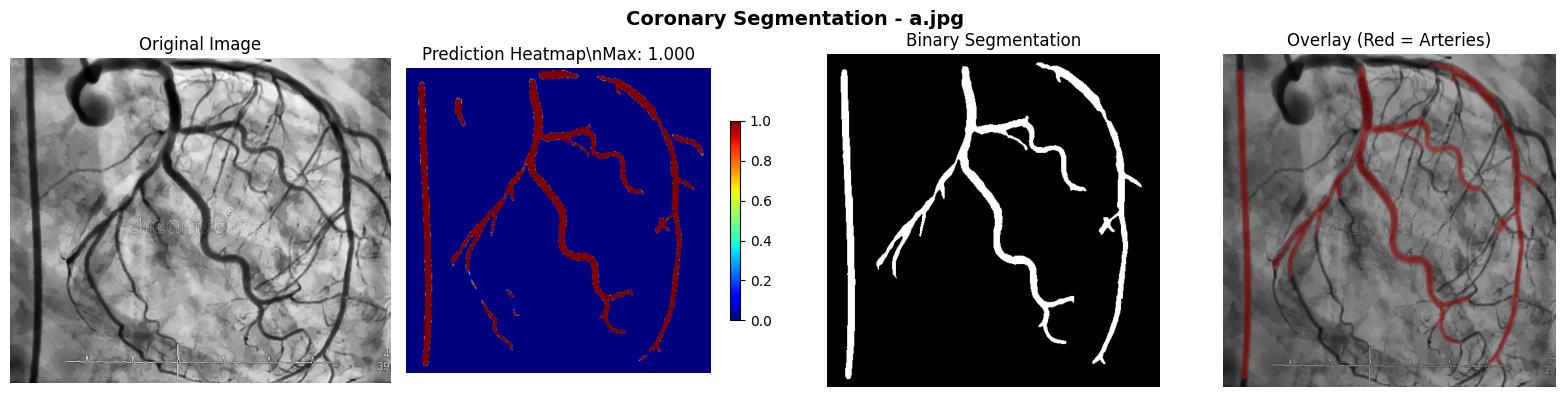

\n✅ INFERENCE COMPLETED!
📊 Results:
   Max confidence: 1.0000
   Mean confidence: 0.0914
   Positive pixels: 21580 (8.23%)


In [105]:
# Pojedynczy obraz - kompletny pipeline
results = full_inference_pipeline("/home/ives/rafal/notebooks/a.jpg", "/home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth", model_type='resunet', resolution=512)

# Upload w Colab
# results = colab_upload_and_inference("/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth")

# Batch folder
# results = batch_inference_folder(folder_path, model_path)

🔮 ENHANCED INFERENCE PIPELINE dla GOOGLE COLAB
🔧 Initializing on device: cuda
✅ Model loaded from epoch 49
📊 Training loss: 0.6178
🔍 Multi-resolution inference: 5 rozdzielczości
📁 Image: c.jpeg
🎯 Threshold: 0.5
📋 Strategy: max_positive_pixels
------------------------------------------------------------
[1/5] Testing 256x256... 🔍 Component analysis:
   Total components found: 5
   Component 1: 402 pixels
   Component 2: 27 pixels
   Component 3: 157 pixels
   Component 4: 268 pixels
   Component 5: 113 pixels
   ❌ Removing component 1 (area: 402 < min_size: 1000)
   ❌ Removing component 2 (area: 27 < min_size: 1000)
   ❌ Removing component 3 (area: 157 < min_size: 1000)
   ❌ Removing component 4 (area: 268 < min_size: 1000)
   ❌ Removing component 5 (area: 113 < min_size: 1000)
   ✅ Kept 0 components (0 pixels total)
   ⚠️  No components above threshold! Largest was 402 pixels.
   💡 Consider lowering min_size to 201 or less
Pixels:    0 (0.0%), Max conf: 1.0000, Components: 0
[2/5] Test

/tmp/ipykernel_285045/3683670628.py:465: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0.03, 1, 0.98])


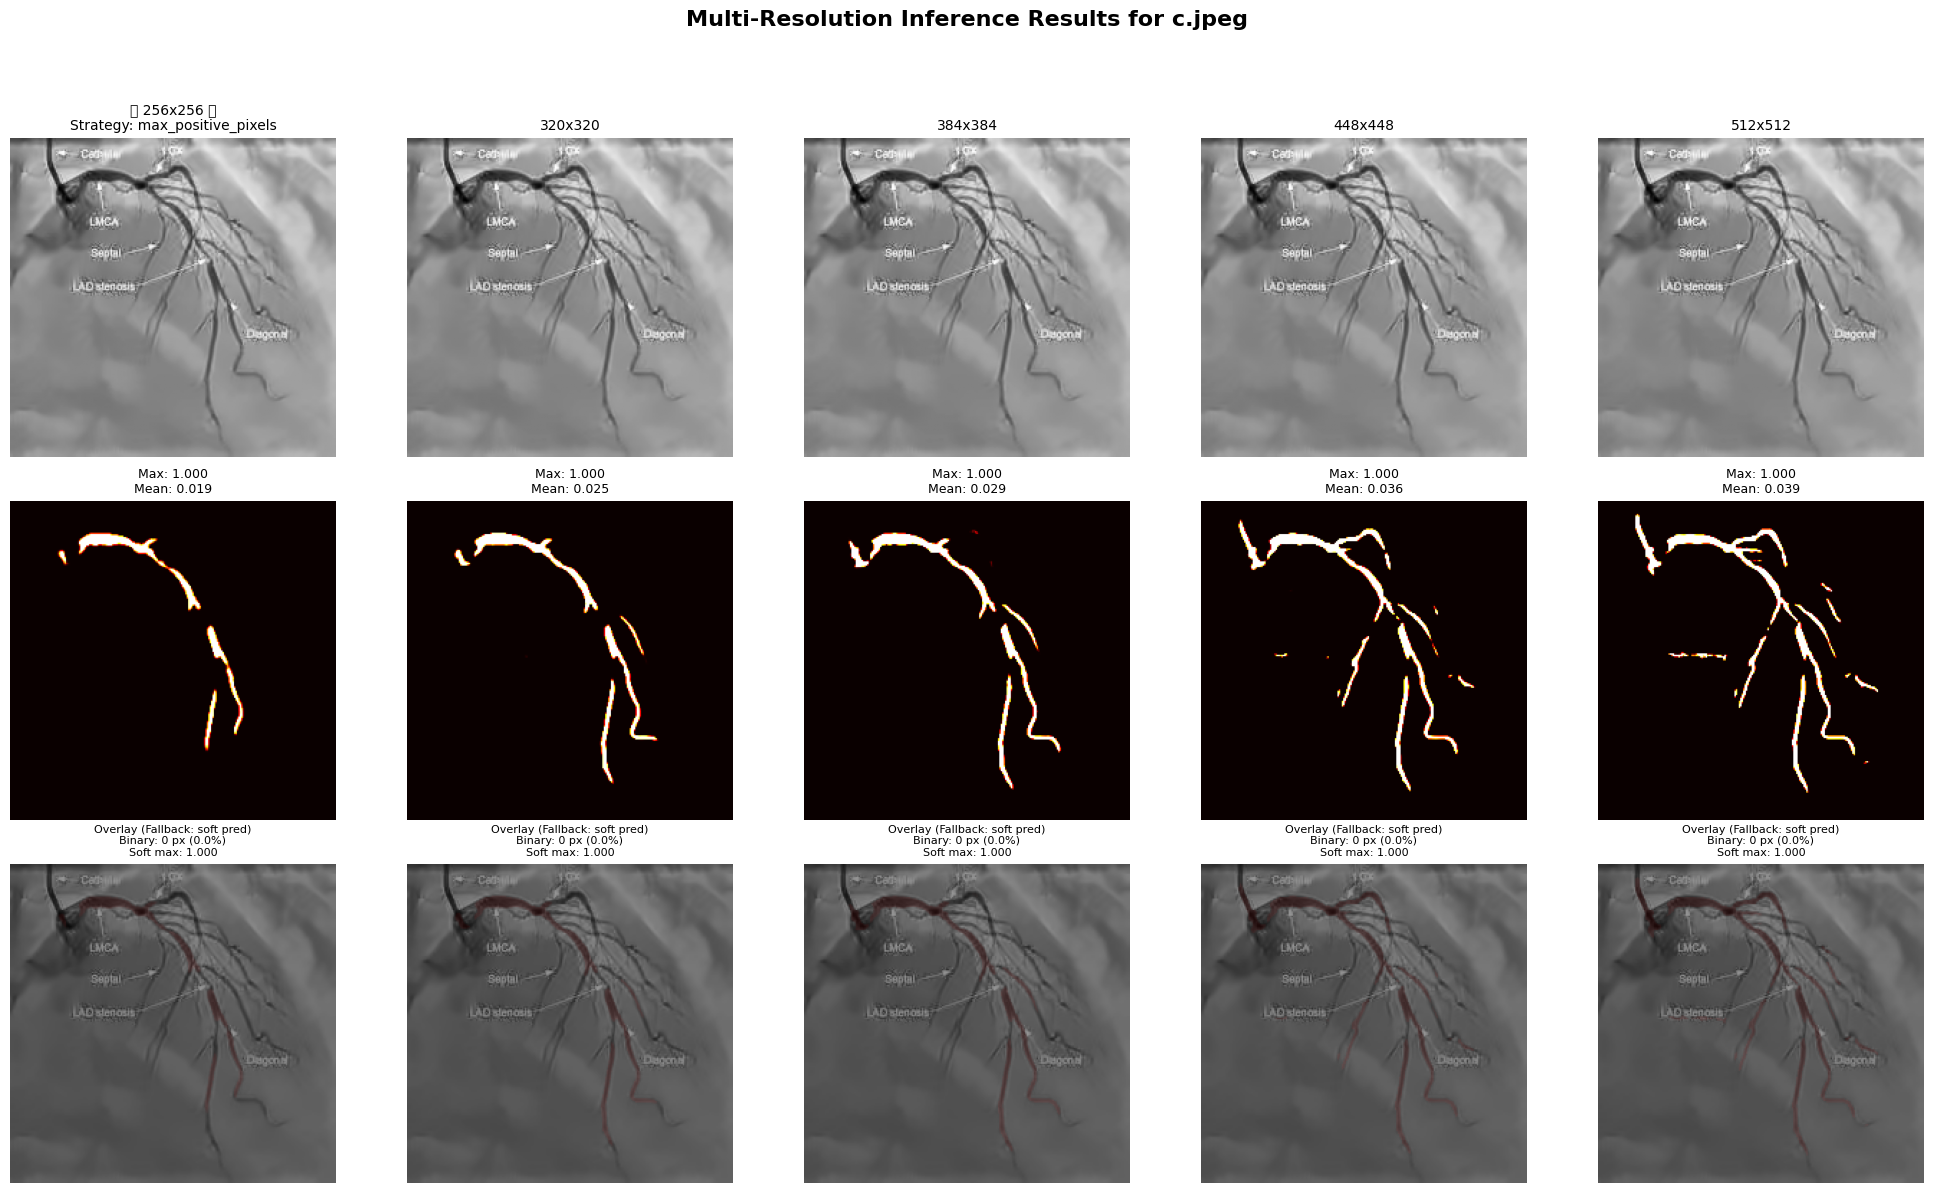


📊 Detailed Results for c.jpeg:
Threshold used: 0.5
--------------------------------------------------------------------------------
       Res  Pixels   Ratio     Max    Mean  Comp
--------------------------------------------------------------------------------
⭐ 256x256      0   0.0% 1.0000 0.0192    0
   320x320      0   0.0% 1.0000 0.0254    0
   384x384      0   0.0% 1.0000 0.0286    0
   448x448      0   0.0% 1.0000 0.0359    0
   512x512      0   0.0% 1.0000 0.0390    0

⚠️  WARNING: No pixels above threshold 0.5
💡 RECOMMENDATION: Try lower threshold (e.g., 0.500 or 0.078)

✅ ENHANCED INFERENCE COMPLETED!
🏆 Best Configuration:
   Resolution: 256x256
   Positive pixels: 0 (0.0%)
   Max confidence: 1.0000
   Mean confidence: 0.0192
   Connected components: 0


In [ ]:
# 🔮 ENHANCED INFERENCE PIPELINE - GOOGLE COLAB

print("🔮 ENHANCED INFERENCE PIPELINE dla GOOGLE COLAB")
print("="*60)

import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import cv2
from typing import Tuple, List, Dict, Optional
import albumentations as A
from albumentations.pytorch import ToTensorV2

class EnhancedInferenceEngine:
    """
    Zaawansowany silnik inferencji z multi-resolution support
    """
    
    def __init__(self, model_path: str, model_type: str = None, 
                 device: str = None, resolutions: List[int] = [256, 320, 384, 448, 512]):
        """
        Inicjalizacja silnika inferencji
        
        Args:
            model_path: Ścieżka do wytrenowanego modelu
            model_type: Typ modelu ('unet', 'enhanced_unet', 'resunet')
            device: Urządzenie ('cuda', 'mps', 'cpu', lub None=auto)
            resolutions: Lista rozdzielczości do testowania
        """
        self.model_path = model_path
        self.model_type = model_type
        self.resolutions = resolutions
        
        # Auto-detect device
        if device is None:
            if torch.cuda.is_available():
                self.device = torch.device("cuda")
            elif torch.backends.mps.is_available():
                self.device = torch.device("mps")
            else:
                self.device = torch.device("cpu")
        else:
            self.device = torch.device(device)
        
        print(f"🔧 Initializing on device: {self.device}")
        
        # Załaduj model
        self.model = self._load_model()
        
    def _load_model(self):
        """Załaduj wytrenowany model"""
        try:
            # Stwórz model
            model = create_model(self.model_type, n_class=1)
            
            # Załaduj wagi
            checkpoint = torch.load(self.model_path, map_location=self.device)
            
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"✅ Model loaded from epoch {checkpoint.get('epoch', 'unknown')}")
                print(f"📊 Training loss: {checkpoint.get('loss', 'unknown'):.4f}")
            else:
                model.load_state_dict(checkpoint)
                print(f"✅ Model loaded (legacy format)")
            
            # Przenieś na device i ustaw eval mode
            model = model.to(self.device)
            model.eval()
            
            return model
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise e
    
    def preprocess_image(self, image_path: str, resolution: int, 
                        apply_preprocessing: bool = True) -> Tuple[torch.Tensor, np.ndarray]:
        """
        Preprocessing pojedynczego obrazu dla konkretnej rozdzielczości
        
        Args:
            image_path: Ścieżka do obrazu lub PIL Image
            resolution: Rozdzielczość do której zmienić obraz
            apply_preprocessing: Czy zastosować CLAHE i denoising
            
        Returns:
            image_tensor: Przetworzony tensor
            image_np: Oryginalny obraz jako numpy array
        """
        
        # Załaduj obraz
        if isinstance(image_path, str):
            image = Image.open(image_path)
        else:
            image = image_path  # Już załadowany PIL Image
        
        # Konwertuj na grayscale
        if image.mode != 'L':
            image = image.convert('L')
        
        # Preprocessing (CLAHE + denoising) - identyczny jak w treningu
        if apply_preprocessing:
            try:
                preprocessor = ImagePreprocessor(
                    apply_clahe=True,
                    apply_denoise=True,
                    clahe_clip_limit=2.0,
                    clahe_tile_grid_size=(8, 8)
                )
                image = preprocessor(image)
            except:
                print("⚠️ ImagePreprocessor not available, skipping preprocessing")
        
        # Konwertuj do numpy (oryginalny rozmiar)
        original_image_np = np.array(image)
        
        # Augmentacje (tylko resize i normalizacja)
        transform = A.Compose([
            A.Resize(resolution, resolution),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ])
        
        # Zastosuj transformacje
        transformed = transform(image=original_image_np)
        image_tensor = transformed['image']
        
        # Dodaj wymiary
        if len(image_tensor.shape) == 2:
            image_tensor = image_tensor.unsqueeze(0)  # Channel dim
        image_tensor = image_tensor.unsqueeze(0)  # Batch dim
        
        return image_tensor, original_image_np
    
    def single_resolution_inference(self, image_path: str, resolution: int, 
                                  threshold: float = 0.5, min_size: int = 500) -> Dict:
        """
        Inferencja dla pojedynczej rozdzielczości
        
        Args:
            image_path: Ścieżka do obrazu
            resolution: Rozdzielczość
            threshold: Próg binaryzacji
            
        Returns:
            results: Słownik z wynikami
        """
        
        # Preprocessing
        image_tensor, original_image = self.preprocess_image(image_path, resolution)
        
        # Inferencja
        with torch.no_grad():
            image_tensor = image_tensor.to(self.device)
            output = self.model(image_tensor)
            prediction = torch.sigmoid(output)
        
        # Resize do oryginalnego rozmiaru
        original_h, original_w = original_image.shape[:2]
        prediction_resized = torch.nn.functional.interpolate(
            prediction, 
            size=(original_h, original_w), 
            mode='bilinear', 
            align_corners=False
        )
        
        # Konwertuj do numpy
        pred_np = prediction_resized.cpu().squeeze().numpy()
        
        # Binaryzacja
        pred_binary = (pred_np > threshold).astype(np.float32)
        
        # Postprocessing - usuń małe komponenty
        pred_binary_clean = self._remove_small_components(pred_binary, min_size=min_size)
        
        # Analiza wyników
        results = {
            'resolution': resolution,
            'prediction_soft': pred_np,
            'prediction_binary': pred_binary_clean,
            'original_image': original_image,
            'max_confidence': float(pred_np.max()),
            'mean_confidence': float(pred_np.mean()),
            'std_confidence': float(pred_np.std()),
            'positive_pixels': int(pred_binary_clean.sum()),
            'positive_ratio': float(pred_binary_clean.mean()),
            'total_pixels': pred_binary_clean.size
        }
        
        # Dodatkowe metryki
        results['confidence_above_threshold'] = float((pred_np > threshold).mean())
        
        # Connected components analysis
        num_components, _ = cv2.connectedComponents(pred_binary_clean.astype(np.uint8))
        results['connected_components'] = num_components - 1  # -1 bo 0 to tło
        
        return results
    
    def multi_resolution_inference(self, image_path: str, threshold: float = 0.5,
                                 selection_strategy: str = 'max_positive_pixels', min_size: int = 500) -> Dict:
        """
        Multi-resolution inference - testuje wszystkie rozdzielczości
        
        Args:
            image_path: Ścieżka do obrazu
            threshold: Próg binaryzacji
            selection_strategy: Strategia wyboru najlepszej rozdzielczości
            
        Returns:
            results: Słownik z wynikami wszystkich rozdzielczości i najlepszą
        """
        
        print(f"🔍 Multi-resolution inference: {len(self.resolutions)} rozdzielczości")
        print(f"📁 Image: {Path(image_path).name}")
        print(f"🎯 Threshold: {threshold}")
        print(f"📋 Strategy: {selection_strategy}")
        print("-" * 60)
        
        all_results = []
        
        # Test każdej rozdzielczości
        for i, resolution in enumerate(self.resolutions, 1):
            print(f"[{i}/{len(self.resolutions)}] Testing {resolution}x{resolution}...", end=" ")
            
            result = self.single_resolution_inference(image_path, resolution, threshold, min_size=min_size)
            all_results.append(result)
            
            print(f"Pixels: {result['positive_pixels']:4d} "
                  f"({result['positive_ratio']:.1%}), "
                  f"Max conf: {result['max_confidence']:.4f}, "
                  f"Components: {result['connected_components']}")
        
        # Wybierz najlepszą rozdzielczość
        best_result = self._select_best_resolution(all_results, selection_strategy)
        
        print(f"\n🏆 Best resolution: {best_result['resolution']}x{best_result['resolution']}")
        print(f"   Strategy: {selection_strategy}")
        print(f"   Positive pixels: {best_result['positive_pixels']} ({best_result['positive_ratio']:.1%})")
        print(f"   Max confidence: {best_result['max_confidence']:.4f}")
        
        return {
            'best_result': best_result,
            'all_results': all_results,
            'strategy_used': selection_strategy,
            'image_path': image_path,
            'threshold': threshold
        }
    
    def _select_best_resolution(self, results: List[Dict], strategy: str) -> Dict:
        """Wybierz najlepszą rozdzielczość według strategii"""
        
        if strategy == 'max_positive_pixels':
            return max(results, key=lambda x: x['positive_pixels'])
        
        elif strategy == 'max_confidence':
            return max(results, key=lambda x: x['mean_confidence'])
        
        elif strategy == 'balanced':
            # Balans: normalizuj obie metryki i weź średnią ważoną
            max_pixels = max(r['positive_pixels'] for r in results)
            max_conf = max(r['mean_confidence'] for r in results)
            
            def balanced_score(r):
                norm_pixels = r['positive_pixels'] / max_pixels if max_pixels > 0 else 0
                norm_conf = r['mean_confidence'] / max_conf if max_conf > 0 else 0
                return 0.7 * norm_pixels + 0.3 * norm_conf
            
            return max(results, key=balanced_score)
        
        elif strategy == 'max_components':
            return max(results, key=lambda x: x['connected_components'])
        
        elif strategy == 'best_quality':
            # Kombinacja wysokiej pewności i reasonable liczby pikseli
            def quality_score(r):
                # Penalizuj bardzo małą liczbę pikseli lub bardzo dużą
                pixel_score = r['positive_ratio']
                if r['positive_ratio'] < 0.01:  # < 1%
                    pixel_score *= 0.1
                elif r['positive_ratio'] > 0.15:  # > 15%
                    pixel_score *= 0.5
                    
                return r['max_confidence'] * 0.6 + pixel_score * 0.4
            
            return max(results, key=quality_score)
        
        else:
            raise ValueError(f"Unknown strategy: {strategy}")
    
    # def _remove_small_components(self, mask: np.ndarray, min_size: int = 1200) -> np.ndarray:
    #     """Usuń małe komponenty z maski"""
    #     mask_uint8 = (mask * 255).astype(np.uint8)
    #     num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_uint8, connectivity=8)
        
    #     mask_cleaned = np.zeros_like(mask, dtype=np.float32)
        
    #     for i in range(1, num_labels):  # pomiń tło (i=0)
    #         if stats[i, cv2.CC_STAT_AREA] >= min_size:
    #             mask_cleaned[labels == i] = 1.0
        
    #     return mask_cleaned

    def _remove_small_components(self, mask: np.ndarray, min_size: int = 500) -> np.ndarray:
        """
        Usuń małe komponenty z maski z lepszą obsługą różnych typów danych
        
        Args:
            mask: Binarna maska (0-1 lub 0-255)
            min_size: Minimalny rozmiar komponentu w pikselach
            
        Returns:
            mask_cleaned: Oczyszczona maska (0.0-1.0)
        """
        
        # Normalizuj maskę do zakresu 0-1
        if mask.max() > 1.0:
            mask_normalized = mask / 255.0
        else:
            mask_normalized = mask
            
        # Konwertuj na binarną maskę uint8
        mask_binary = (mask_normalized > 0.5).astype(np.uint8)
        
        # Znajdź komponenty połączone
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
            mask_binary, connectivity=8
        )

        print(f"🔍 Component analysis:")
        print(f"   Total components found: {num_labels - 1}")  # -1 bo 0 to tło
        
        if num_labels <= 1:  # Tylko tło
            print(f"   No foreground components found")
            return np.zeros_like(mask, dtype=np.float32)

        # Pokaż wszystkie komponenty
        areas = []
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            areas.append(area)
            print(f"   Component {i}: {area} pixels")

        # Stwórz nową pustą maskę
        mask_cleaned = np.zeros_like(mask, dtype=np.float32)
        
        # Zachowaj tylko komponenty większe niż min_size
        kept_components = 0
        total_kept_pixels = 0
        
        for i in range(1, num_labels):
            area = stats[i, cv2.CC_STAT_AREA]
            if area >= min_size:
                mask_cleaned[labels == i] = 1.0
                kept_components += 1
                total_kept_pixels += area
            else:
                print(f"   ❌ Removing component {i} (area: {area} < min_size: {min_size})")

        print(f"   ✅ Kept {kept_components} components ({total_kept_pixels} pixels total)")
        
        # Jeśli żaden komponent nie został zachowany, ale istnieją komponenty
        if kept_components == 0 and len(areas) > 0:
            largest_area = max(areas)
            print(f"   ⚠️  No components above threshold! Largest was {largest_area} pixels.")
            print(f"   💡 Consider lowering min_size to {largest_area // 2} or less")

        return mask_cleaned

    def visualize_multi_resolution_results(self, inference_results: Dict,
                                           save_path: Optional[str] = None):
        """
        Wizualizuj wyniki inferencji wielorozdzielczej.

        Prezentuje oryginalny obraz, mapę ciepła predykcji oraz binarną maskę
        dla każdej testowanej rozdzielczości, wyróżniając najlepszy wynik.

        Args:
            inference_results: Wyniki zwrócone przez `multi_resolution_inference`.
            save_path: Opcjonalna ścieżka do zapisania wykresu. Jeśli None, wykres jest tylko wyświetlany.
        """

        all_results = inference_results['all_results']
        best_result = inference_results['best_result']
        image_name = Path(inference_results['image_path']).name
        threshold = inference_results['threshold']

        n_resolutions = len(all_results)
        fig, axes = plt.subplots(3, n_resolutions, figsize=(4 * n_resolutions, 12))

        # Handle case with single resolution more gracefully for axes indexing
        if n_resolutions == 1:
            axes = axes.reshape(3, 1)

        for i, result in enumerate(all_results):
            resolution = result['resolution']
            original = result['original_image']
            pred_soft = result['prediction_soft']
            pred_binary = result['prediction_binary']

            is_best = (resolution == best_result['resolution'])

            # 1. Oryginalny obraz
            axes[0, i].imshow(original, cmap='gray')
            title = f'{resolution}x{resolution}'
            if is_best:
                title = f"⭐ {title} ⭐\nStrategy: {inference_results['strategy_used']}"
                # Highlight best result
                for spine in axes[0, i].spines.values():
                    spine.set_edgecolor('green')
                    spine.set_linewidth(3)
            axes[0, i].set_title(title, fontsize=10)
            axes[0, i].axis('off')

            # 2. Soft prediction (heatmapa)
            im = axes[1, i].imshow(pred_soft, cmap='hot', vmin=0, vmax=1)
            axes[1, i].set_title(f'Max: {result["max_confidence"]:.3f}\nMean: {result["mean_confidence"]:.3f}', fontsize=9)
            axes[1, i].axis('off')

            # 3. Overlay - POPRAWIONE (pokazuje tylko obiekty po filtracji)
            # Stwórz overlay z oryginalnym obrazem i oczyszczoną binarną predykcją
            overlay = cv2.cvtColor(original, cv2.COLOR_GRAY2RGB)
            
            # Użyj oczyszczonej binarnej maski (po usunięciu małych komponentów)
            # To zapewni zgodność między overlay a statystykami
            binary_scaled = (pred_binary * 255).astype(np.uint8)
            
            # Stwórz kolorową maskę (czerwoną) z oczyszczonej binarnej maski
            red_mask = np.zeros_like(overlay)
            red_mask[:, :, 0] = binary_scaled  # Czerwony kanał z oczyszczonej maski
            
            # Jeśli nie ma żadnych obiektów po filtracji, pokaż soft prediction z niską intensywnością
            if pred_binary.sum() == 0:
                # Fallback: użyj soft prediction ale z bardzo niską intensywnością
                soft_scaled = (pred_soft * 50).astype(np.uint8)  # Bardzo słabe
                red_mask[:, :, 0] = soft_scaled
                # Dodaj informację o fallback
                overlay_info = "(Fallback: soft pred)"
            else:
                overlay_info = "(Filtered binary)"
            
            # Blend oryginalny obraz z kolorową maską
            overlay_blended = cv2.addWeighted(overlay, 0.6, red_mask, 0.4, 0)
            
            axes[2, i].imshow(overlay_blended)
            
            # Informacje o wynikach
            binary_pixels = int(pred_binary.sum())
            max_soft_value = float(pred_soft.max())
            mean_soft_value = float(pred_soft.mean())
            
            # Dodaj informacje o threshold i wynikach
            title_text = f'Overlay {overlay_info}\n'
            title_text += f'Binary: {binary_pixels} px ({result["positive_ratio"]:.1%})\n'
            title_text += f'Soft max: {max_soft_value:.3f}'
            
            axes[2, i].set_title(title_text, fontsize=8)
            axes[2, i].axis('off')

        plt.suptitle(f'Multi-Resolution Inference Results for {image_name}',
                     fontsize=16, fontweight='bold', y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"💾 Visualization saved to: {save_path}")

        plt.show()

        # Szczegółowe wyniki w konsoli
        print(f"\n📊 Detailed Results for {image_name}:")
        print(f"Threshold used: {threshold}")
        print("-" * 80)
        print(f"{'':2s} {'Res':>7s} {'Pixels':>7s} {'Ratio':>7s} {'Max':>7s} {'Mean':>7s} {'Comp':>5s}")
        print("-" * 80)

        for result in all_results:
            marker = "⭐" if result['resolution'] == best_result['resolution'] else "  "
            print(f"{marker} {result['resolution']:3d}x{result['resolution']:3d} "
                  f"{result['positive_pixels']:6d} "
                  f"{result['positive_ratio']:6.1%} "
                  f"{result['max_confidence']:6.4f} "
                  f"{result['mean_confidence']:6.4f} "
                  f"{result['connected_components']:4d}")
        
        # Dodaj rekomendację dotyczącą threshold
        if all(r['positive_pixels'] == 0 for r in all_results):
            max_conf = max(r['max_confidence'] for r in all_results)
            mean_conf = max(r['mean_confidence'] for r in all_results)
            print(f"\n⚠️  WARNING: No pixels above threshold {threshold}")
            print(f"💡 RECOMMENDATION: Try lower threshold (e.g., {max_conf*0.5:.3f} or {mean_conf*2:.3f})")
    


engine = EnhancedInferenceEngine(
        model_path="/home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth",
        model_type='resunet'    ) 
image_path="/home/ives/rafal/notebooks/c.jpeg"
threshold=0.5

# print(f"\n2️⃣ Running multi-resolution inference...")
results = engine.multi_resolution_inference(
image_path=image_path,
threshold=threshold, min_size=1000)

# prediction_binary_np = results['best_result'].cpu().squeeze().numpy()
# prediction_binary_clean = remove_small_components_from_mask(prediction_binary_np, min_size=1000)

# # Konwertuj z powrotem do tensora
# prediction_binary = torch.tensor(prediction_binary_clean).unsqueeze(0).unsqueeze(0).to(device).float()
# 3. Wizualizacja
print(f"\n3️⃣ Visualizing results...")
engine.visualize_multi_resolution_results(results)

# 4. Podsumowanie
best = results['best_result']
print(f"\n✅ ENHANCED INFERENCE COMPLETED!")
print(f"🏆 Best Configuration:")
print(f"   Resolution: {best['resolution']}x{best['resolution']}")
print(f"   Positive pixels: {best['positive_pixels']} ({best['positive_ratio']:.1%})")
print(f"   Max confidence: {best['max_confidence']:.4f}")
print(f"   Mean confidence: {best['mean_confidence']:.4f}")
print(f"   Connected components: {best['connected_components']}")

# Dodaj silnik do wyników
results['engine'] = engine

# results = full_inference_pipeline("/home/ives/rafal/notebooks/c.jpeg", "/home/ives/rafal/notebooks/best_resunet_dice_32_51.pth", model_type='resunet', resolution=384)

# Upload w Colab
# results = colab_upload_and_inference("/content/drive/MyDrive/Colab Notebooks/best_resunet_monai_dice.pth")

# Batch folder
# results = batch_inference_folder(folder_path, model_path)

In [ ]:
# 🎯 MULTI-SCALE TRAINING SOLUTIONS
# Rozwiązania problemów różnych rozdzielczości na etapie treningu

import random
from typing import List, Tuple, Union
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class MultiScaleDataset(Dataset):
    """
    Dataset z multi-scale training - losowe rozdzielczości podczas treningu
    """
    
    def __init__(self, image_paths: List[str], mask_paths: List[str],
                 resolutions: List[int] = [256, 320, 384],
                 min_resolution: int = 256, max_resolution: int = 512,
                 dynamic_scaling: bool = True,
                 train: bool = True, apply_preprocessing: bool = True):
        """
        Args:
            image_paths: Lista ścieżek do obrazów
            mask_paths: Lista ścieżek do masek
            resolutions: Lista dozwolonych rozdzielczości (jeśli dynamic_scaling=False)
            min_resolution: Minimalna rozdzielczość (jeśli dynamic_scaling=True)
            max_resolution: Maksymalna rozdzielczość (jeśli dynamic_scaling=True)
            dynamic_scaling: Czy użyć ciągłego zakresu rozdzielczości
            train: Czy to dataset treningowy
            apply_preprocessing: Czy zastosować preprocessing
        """
        
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resolutions = resolutions
        self.min_resolution = min_resolution
        self.max_resolution = max_resolution
        self.dynamic_scaling = dynamic_scaling
        self.train = train
        self.apply_preprocessing = apply_preprocessing
        
        # Preprocessing
        try:
            if apply_preprocessing:
                self.preprocessor = ImagePreprocessor(
                    apply_clahe=True,
                    apply_denoise=True,
                    clahe_clip_limit=2.0,
                    clahe_tile_grid_size=(8, 8)
                )
            else:
                self.preprocessor = None
        except:
            print("⚠️ ImagePreprocessor not available")
            self.preprocessor = None
    
    def get_random_resolution(self) -> int:
        """Zwróć losową rozdzielczość"""
        if self.dynamic_scaling:
            # Ciągły zakres z krokiem 32
            resolution = random.randrange(self.min_resolution, self.max_resolution + 1, 32)
        else:
            # Z predefiniowanej listy
            resolution = random.choice(self.resolutions)
        
        return resolution
    
    def get_transforms(self, resolution: int):
        """Zwróć transformacje dla danej rozdzielczości"""
        
        scale_factor = resolution / 256.0
        if self.train:
            # Augmentacje treningowe
            return A.Compose([
                
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.2),
                A.RandomRotate90(p=0.5),
                A.Rotate(limit=15, p=0.3),
                # 🔧 ADAPTIVE ELASTIC TRANSFORM
                A.ElasticTransform(
                    alpha=1 * scale_factor,           # Skaluj siłę
                    sigma=50 * scale_factor,          # Skaluj zasięg
                    p=0.2
                ),
                
                # 🔧 ADAPTIVE DISTORTIONS
                A.GridDistortion(
                    num_steps=int(5 * scale_factor),  # Więcej kroków dla wyższej rozdzielczości
                    p=0.2
                ),
                A.OpticalDistortion(
                    distort_limit=0.05 / scale_factor,  # Mniejsze zniekształcenia na wysokiej rozdzielczości
                    p=0.2
                ),
                
                # 🔧 BRIGHTNESS/CONTRAST - bez zmian (względne)
                A.RandomBrightnessContrast(
                    brightness_limit=0.1, 
                    contrast_limit=0.1, 
                    p=0.3
                ),
                
                # 🔧 ADAPTIVE NOISE
                A.GaussNoise(
                    var_limit=(10.0 * scale_factor, 50.0 * scale_factor),
                    p=0.2
                ),
            
                # 🔧 ADAPTIVE BLUR
                A.Blur(
                    blur_limit=max(3, int(5 * scale_factor)),  # Min 3, skalowany
                ),
                A.Resize(resolution, resolution),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ])
        else:
            # Tylko resize i normalizacja dla walidacji
            return A.Compose([
                A.Resize(resolution, resolution),
                A.Normalize(mean=(0.5,), std=(0.5,)),
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Losowa rozdzielczość dla każdego obrazu (tylko w treningu)
        if self.train:
            resolution = self.get_random_resolution()
        else:
            # Stała rozdzielczość dla walidacji
            resolution = self.resolutions[len(self.resolutions)//2] if self.resolutions else 384
        
        # Załaduj obraz i maskę
        image = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx])
        
        # Konwertuj na grayscale
        if image.mode != 'L':
            image = image.convert('L')
        if mask.mode != 'L':
            mask = mask.convert('L')
        
        # Preprocessing obrazu
        if self.preprocessor is not None:
            image = self.preprocessor(image)
        
        # Konwertuj do numpy
        image_np = np.array(image)
        mask_np = np.array(mask)
        
        # Normalizacja maski do 0-1
        mask_np = (mask_np > 127).astype(np.float32)
        
        # Zastosuj transformacje z konkretną rozdzielczością
        transform = self.get_transforms(resolution)
        
        transformed = transform(image=image_np, mask=mask_np)
        image_tensor = transformed['image']
        mask_tensor = transformed['mask']
        
        # Dodaj channel dimension jeśli potrzeba
        if len(image_tensor.shape) == 2:
            image_tensor = image_tensor.unsqueeze(0)
        if len(mask_tensor.shape) == 2:
            mask_tensor = mask_tensor.unsqueeze(0)
        
        return image_tensor, mask_tensor


class ProgressiveResizer:
    """
    Progressive resizing - stopniowo zwiększa rozdzielczość podczas treningu
    """
    
    def __init__(self, start_resolution: int = 256, end_resolution: int = 512,
                 progression_epochs: List[int] = [10, 20, 30]):
        """
        Args:
            start_resolution: Rozdzielczość startowa
            end_resolution: Rozdzielczość końcowa  
            progression_epochs: Epoki w których zwiększać rozdzielczość
        """
        self.start_resolution = start_resolution
        self.end_resolution = end_resolution
        self.progression_epochs = progression_epochs
        
        # Oblicz rozdzielczości dla każdej fazy
        n_phases = len(progression_epochs) + 1
        resolution_step = (end_resolution - start_resolution) // n_phases
        
        self.phase_resolutions = []
        for i in range(n_phases):
            resolution = start_resolution + i * resolution_step
            self.phase_resolutions.append(resolution)
        
        self.current_phase = 0
        print(f"🎯 Progressive resizing initialized:")
        print(f"   Phases: {self.phase_resolutions}")
        print(f"   Switch epochs: {self.progression_epochs}")
    
    def get_current_resolution(self, epoch: int) -> int:
        """Zwróć aktualną rozdzielczość dla danej epoki"""
        
        # Sprawdź czy trzeba przejść do następnej fazy
        for i, switch_epoch in enumerate(self.progression_epochs):
            if epoch >= switch_epoch:
                self.current_phase = i + 1
        
        # Ostatnia faza
        if self.current_phase >= len(self.phase_resolutions):
            self.current_phase = len(self.phase_resolutions) - 1
        
        return self.phase_resolutions[self.current_phase]
    
    def update_dataset_resolution(self, dataset: MultiScaleDataset, epoch: int):
        """Zaktualizuj rozdzielczość w datasecie"""
        new_resolution = self.get_current_resolution(epoch)
        
        if hasattr(dataset, 'current_resolution'):
            if dataset.current_resolution != new_resolution:
                print(f"📈 Epoch {epoch}: Switching resolution {dataset.current_resolution} → {new_resolution}")
        else:
            print(f"📈 Epoch {epoch}: Setting resolution to {new_resolution}")
        
        dataset.current_resolution = new_resolution
        
        # Dla progressive resizing używamy stałej rozdzielczości (nie losowej)
        dataset.resolutions = [new_resolution]

class BCEAndDiceLoss(nn.Module):
    """
    Połączenie Binary Cross-Entropy i Dice Loss
    """
    
    def __init__(self, bce_weight: float = 0.5, dice_weight: float = 0.5):
        """
        Args:
            bce_weight: Waga dla Binary Cross-Entropy
            dice_weight: Waga dla Dice Loss
        """
        super().__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = DiceLoss()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
    
    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Oblicz stratę
        
        Args:
            predictions: Predykcje modelu [B, C, H, W]
            targets: Ground truth [B, C, H, W]
        """
        
        bce = self.bce_loss(predictions, targets)
        dice = self.dice_loss.compute(torch.sigmoid(predictions), targets)
        
        return self.bce_weight * bce + self.dice_weight * dice
    
class MultiScaleLoss(nn.Module):
    """
    Multi-scale loss function uwzględniająca różne skale
    """
    
    def __init__(self, scales: List[float] = [1.0, 0.75, 0.5],
                 loss_weights: List[float] = [1.0, 0.5, 0.25],
                 base_loss: str = 'bce_dice'):
        """
        Args:
            scales: Lista skal do obliczenia loss (1.0 = pełna rozdzielczość)
            loss_weights: Wagi dla każdej skali
            base_loss: Bazowa funkcja straty ('dice', 'bce', 'focal')
        """
        super().__init__()
        
        self.scales = scales
        self.loss_weights = loss_weights
        
        # Wybierz bazową funkcję straty
        if base_loss == 'dice':
            self.base_loss_fn = DiceLoss()
        elif base_loss == 'bce':
            self.base_loss_fn = nn.BCEWithLogitsLoss()
        elif base_loss == 'focal':
            self.base_loss_fn = FocalLoss()
        elif base_loss == 'bce_dice':
            self.base_loss_fn = BCEAndDiceLoss()
        else:
            raise ValueError(f"Unsupported loss: {base_loss}")
    
    def forward(self, predictions: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        Oblicz multi-scale loss
        
        Args:
            predictions: Predykcje modelu [B, C, H, W]
            targets: Ground truth [B, C, H, W]
        """
        
        total_loss = 0.0
        
        for scale, weight in zip(self.scales, self.loss_weights):
            if scale == 1.0:
                # Pełna rozdzielczość
                scaled_pred = predictions
                scaled_target = targets
            else:
                # Przeskaluj do mniejszej rozdzielczości
                h, w = int(predictions.shape[2] * scale), int(predictions.shape[3] * scale)
                
                scaled_pred = F.interpolate(predictions, size=(h, w), mode='bilinear', align_corners=False)
                scaled_target = F.interpolate(targets, size=(h, w), mode='bilinear', align_corners=False)
            
            # Oblicz loss dla tej skali
            if isinstance(self.base_loss_fn, nn.BCEWithLogitsLoss):
                # BCEWithLogitsLoss oczekuje logits
                scale_loss = self.base_loss_fn(scaled_pred, scaled_target)
            else:
                # Dice/Focal oczekuje prawdopodobieństw
                scaled_pred_sigmoid = torch.sigmoid(scaled_pred)
                scale_loss = self.base_loss_fn.compute(scaled_pred_sigmoid, scaled_target)
            
            total_loss += weight * scale_loss
        
        return total_loss




✅ MULTI-SCALE TRAINING COMPONENTS READY!

🎯 Dostępne klasy:
- MultiScaleDataset - dataset z losowymi rozdzielczościami
- ProgressiveResizer - stopniowe zwiększanie rozdzielczości
- MultiScaleLoss - loss function uwzględniający różne skale

💡 Przykład użycia:

# Multi-scale dataset
dataset = MultiScaleDataset(
    image_paths=train_images,
    mask_paths=train_masks,
    resolutions=[256, 320, 384, 448, 512],
    dynamic_scaling=True,
    train=True
)

# Progressive resizing
resizer = ProgressiveResizer(
    start_resolution=256,
    end_resolution=512,
    progression_epochs=[10, 20, 30]
)

# Multi-scale loss
loss_fn = MultiScaleLoss(
    scales=[1.0, 0.75, 0.5],
    loss_weights=[1.0, 0.5, 0.25],
    base_loss='dice'
)



In [31]:
# TENSORBOARD - Monitoring treningu w czasie rzeczywistym

# Uruchom TensorBoard (odkomentuj poniższe linie)
%load_ext tensorboard
%tensorboard --logdir=runs

print("📱 TensorBoard:")
print("Odkomentuj linie powyżej aby uruchomić TensorBoard")
print("\\nMonitoruje:")
print("- Stratę treningu i walidacji")
print("- Metryki (Dice, IoU, BCE)")
print("- Parametry modelu")
print("- Histogramy wag")


📱 TensorBoard:
Odkomentuj linie powyżej aby uruchomić TensorBoard
\nMonitoruje:
- Stratę treningu i walidacji
- Metryki (Dice, IoU, BCE)
- Parametry modelu
- Histogramy wag


In [ ]:
# 🚀 ENHANCED MULTI-SCALE TRAINING FUNCTION

def train_model_multiscale(model, train_dataset, val_dataset, 
                          optimizer, scheduler,
                          epochs=100, batch_size=32,
                          use_progressive_resizing=True,
                          use_multiscale_loss=True,
                          loss_function_name='dice',
                          save_path="best_multiscale_model.pth",
                          enable_tensorboard=True,
                          log_dir="runs"):
    """
    Ulepszona funkcja treningu z obsługą multi-scale training i TensorBoard
    
    Args:
        model: Model do treningu
        train_dataset: Dataset treningowy (MultiScaleDataset)
        val_dataset: Dataset walidacyjny
        optimizer: Optymalizator
        scheduler: Scheduler learning rate
        epochs: Liczba epok
        batch_size: Rozmiar batcha
        use_progressive_resizing: Czy użyć progressive resizing
        use_multiscale_loss: Czy użyć multi-scale loss
        loss_function_name: Nazwa funkcji straty
        save_path: Ścieżka do zapisania najlepszego modelu
        enable_tensorboard: Czy włączyć logowanie do TensorBoard
        log_dir: Katalog dla logów TensorBoard
    """
    
    print(f"🚀 MULTI-SCALE TRAINING STARTED")
    print(f"="*60)
    print(f"🔧 Configuration:")
    print(f"   Epochs: {epochs}")
    print(f"   Batch size: {batch_size}")
    print(f"   Progressive resizing: {use_progressive_resizing}")
    print(f"   Multi-scale loss: {use_multiscale_loss}")
    print(f"   Base loss: {loss_function_name}")
    print(f"   TensorBoard: {enable_tensorboard}")
    
    # TensorBoard writer
    if enable_tensorboard:
        from datetime import datetime
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        experiment_name = f"multiscale_{loss_function_name}_{timestamp}"
        if use_progressive_resizing:
            experiment_name += "_progressive"
        if use_multiscale_loss:
            experiment_name += "_multiscale_loss"
        
        writer = SummaryWriter(log_dir=f"{log_dir}/{experiment_name}")
        print(f"   TensorBoard logs: {log_dir}/{experiment_name}")
        print(f"   Run: tensorboard --logdir={log_dir}")
    else:
        writer = None
    
    # Progressive resizer jeśli potrzeba
    if use_progressive_resizing:
        resizer = ProgressiveResizer(
            start_resolution=256,
            end_resolution=512,
            progression_epochs=[epochs//4, epochs//2, 3*epochs//4]
        )
    
    # Multi-scale loss jeśli potrzeba
    if use_multiscale_loss:
        loss_function = MultiScaleLoss(
            scales=[1.0, 0.75, 0.5],
            loss_weights=[1.0, 0.5, 0.25],
            base_loss=loss_function_name
        )
    else:
        # Standardowa funkcja straty
        if loss_function_name == 'dice':
            loss_function = DiceLoss()
        elif loss_function_name == 'bce':
            loss_function = nn.BCEWithLogitsLoss()
        elif loss_function_name == 'focal':
            loss_function = FocalLoss()
        else:
            loss_function = DiceLoss()
    
    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    # Model na device
    model = model.to(device)
    
    # Historia treningu
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': [],
        'val_sensitivity': [],
        'val_precision': [],
        'val_f1': [],
        'resolutions': []  # Śledzenie rozdzielczości
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 10
    global_step = 0  # Dla TensorBoard
    
    print(f"\n📊 TRAINING PROGRESS:")
    print("-" * 80)
    
    for epoch in range(epochs):
        # Update progressive resizing
        if use_progressive_resizing:
            current_resolution = resizer.get_current_resolution(epoch)
            resizer.update_dataset_resolution(train_dataset, epoch)
            history['resolutions'].append(current_resolution)
        else:
            # Dla multi-scale dataset śledzenie średniej rozdzielczości
            if hasattr(train_dataset, 'resolutions'):
                avg_resolution = sum(train_dataset.resolutions) / len(train_dataset.resolutions)
                history['resolutions'].append(avg_resolution)
            else:
                history['resolutions'].append(384)  # Default
        
        # ===== TRAINING PHASE =====
        model.train()
        train_loss = 0.0
        train_batches = 0
        
        train_progress = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [TRAIN]')
        
        for batch_idx, (inputs, labels) in enumerate(train_progress):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Oblicz loss
            if use_multiscale_loss:
                loss = loss_function(outputs, labels)
            else:
                if loss_function_name == 'bce':
                    loss = loss_function(outputs, labels)
                else:
                    predictions = torch.sigmoid(outputs)
                    loss = loss_function.compute(predictions, labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            
            # Akumuluj loss
            train_loss += loss.item()
            train_batches += 1
            global_step += 1
            
            # TensorBoard logging - batch level
            if writer and batch_idx % 10 == 0:  # Log co 10 batchy
                writer.add_scalar('Batch_Loss/Train', loss.item(), global_step)
                writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], global_step)
                if use_progressive_resizing:
                    writer.add_scalar('Resolution', current_resolution, global_step)
            
            # Update progress bar
            current_train_loss = train_loss / train_batches
            train_progress.set_postfix({
                'Loss': f'{current_train_loss:.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
            })
        
        avg_train_loss = train_loss / train_batches
        history['train_loss'].append(avg_train_loss)
        
        # ===== VALIDATION PHASE =====
        model.eval()
        val_loss = 0.0
        val_batches = 0
        val_metrics = {
            'fg_dice': 0.0,
            'sensitivity': 0.0,
            'precision': 0.0,
            'f1': 0.0
        }
        
        val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{epochs} [VAL]')
        
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                predictions = torch.sigmoid(outputs)
                
                # Validation loss
                if use_multiscale_loss:
                    loss = loss_function(outputs, labels)
                else:
                    if loss_function_name == 'bce':
                        loss = loss_function(outputs, labels)
                    else:
                        loss = loss_function.compute(predictions, labels)
                                                      
                val_loss += loss.item()
                val_batches += 1
                
                # Metryki dla każdego obrazu w batchu
                batch_metrics = {key: 0.0 for key in val_metrics.keys()}
                
                for i in range(inputs.size(0)):
                    fg_dice = foreground_dice_score(predictions[i:i+1], labels[i:i+1])
                    sensitivity = sensitivity_recall(predictions[i:i+1], labels[i:i+1])
                    precision = precision_score(predictions[i:i+1], labels[i:i+1])
                    f1 = f1_score_balanced(predictions[i:i+1], labels[i:i+1])
                    
                    batch_metrics['fg_dice'] += fg_dice
                    batch_metrics['sensitivity'] += sensitivity
                    batch_metrics['precision'] += precision
                    batch_metrics['f1'] += f1
                
                # Średnie dla batcha
                batch_size = inputs.size(0)
                for key in batch_metrics:
                    batch_metrics[key] /= batch_size
                    val_metrics[key] += batch_metrics[key]
                
                # Update progress bar
                current_val_loss = val_loss / val_batches
                current_dice = val_metrics['fg_dice'] / val_batches
                val_progress.set_postfix({
                    'Loss': f'{current_val_loss:.4f}',
                    'Dice': f'{current_dice:.4f}'
                })
        
        # Średnie metryki walidacyjne
        avg_val_loss = val_loss / val_batches
        for key in val_metrics:
            val_metrics[key] /= val_batches
        
        # Dodaj do historii
        history['val_loss'].append(avg_val_loss)
        history['val_dice'].append(val_metrics['fg_dice'])
        history['val_sensitivity'].append(val_metrics['sensitivity'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_f1'].append(val_metrics['f1'])
        
        # TensorBoard logging - epoch level
        if writer:
            writer.add_scalar('Epoch_Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Epoch_Loss/Validation', avg_val_loss, epoch)
            writer.add_scalar('Metrics/Dice_Score', val_metrics['fg_dice'], epoch)
            writer.add_scalar('Metrics/Sensitivity', val_metrics['sensitivity'], epoch)
            writer.add_scalar('Metrics/Precision', val_metrics['precision'], epoch)
            writer.add_scalar('Metrics/F1_Score', val_metrics['f1'], epoch)
            
            # Log rozdzielczość
            current_res = history['resolutions'][-1]
            writer.add_scalar('Training/Resolution', current_res, epoch)
            
            # Log histogramy wag (co 5 epok)
            if epoch % 5 == 0:
                for name, param in model.named_parameters():
                    if param.requires_grad and param.grad is not None:
                        writer.add_histogram(f'Weights/{name}', param.data, epoch)
                        writer.add_histogram(f'Gradients/{name}', param.grad.data, epoch)
        
        # Learning rate scheduler
        if hasattr(scheduler, 'step'):
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            else:
                scheduler.step()
        
        # Print epoch summary
        current_res = history['resolutions'][-1]
        print(f"\nEpoch {epoch+1}/{epochs} Summary:")
        print(f"  Resolution: {current_res:.0f}x{current_res:.0f}")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Val Loss: {avg_val_loss:.4f}")
        print(f"  Val Dice: {val_metrics['fg_dice']:.4f}")
        print(f"  Val F1: {val_metrics['f1']:.4f}")
        print(f"  LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping i zapisywanie najlepszego modelu
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
            # Zapisz najlepszy model
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if hasattr(scheduler, 'state_dict') else None,
                'epoch': epoch + 1,
                'loss': best_val_loss,
                'metrics': val_metrics,
                'history': history,
                'model_type': getattr(model, '_get_name', lambda: 'unknown')(),
                'config': {
                    'epochs': epochs,
                    'batch_size': batch_size,
                    'use_progressive_resizing': use_progressive_resizing,
                    'use_multiscale_loss': use_multiscale_loss,
                    'loss_function': loss_function_name
                }
            }
            
            torch.save(checkpoint, save_path)
            print(f"✅ Best model saved: {save_path}")
            
            # TensorBoard - zapisz najlepszy model
            if writer:
                writer.add_text('Best_Model', f'Epoch {epoch+1}, Loss: {best_val_loss:.4f}', epoch)
        else:
            patience_counter += 1
            
        # Early stopping
        if patience_counter >= patience:
            print(f"\n⏹️ Early stopping triggered (patience={patience})")
            break
        
        print("-" * 80)
    
    # Zamknij TensorBoard writer
    if writer:
        writer.close()
        print(f"\n📊 TensorBoard logs saved to: {log_dir}/{experiment_name}")
        print(f"🚀 To view logs run: tensorboard --logdir={log_dir}")
    
    print(f"\n🎉 MULTI-SCALE TRAINING COMPLETED!")
    print(f"✅ Best validation loss: {best_val_loss:.4f}")
    print(f"💾 Model saved: {save_path}")
    
    return model, history


def setup_multiscale_training(data_path=path, model_type='resunet',
                              use_progressive=True, use_multiscale_loss=True,
                              batch_size=32, lr=0.01):
    """
    Przygotuj multi-scale training
    """
    
    print(f"🔧 SETTING UP MULTI-SCALE TRAINING")
    print(f"="*50)
    
    # Przygotuj ścieżki
    imgs_path = os.path.join(data_path, "imgs")
    masks_path = os.path.join(data_path, "masks")
    
    img_files = sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
    mask_files = sorted(glob.glob(os.path.join(masks_path, "*.png")))
    
    # Split na train/val
    split_idx = int(0.8 * len(img_files))
    
    train_images = img_files[:split_idx]
    train_masks = mask_files[:split_idx]
    val_images = img_files[split_idx:]
    val_masks = mask_files[split_idx:]
    
    print(f"📊 Dataset split:")
    print(f"   Train: {len(train_images)} images")
    print(f"   Validation: {len(val_images)} images")
    
    # Stwórz datasety
    if use_progressive:
        # Progressive resizing - zaczynamy od małych rozdzielczości
        train_dataset = MultiScaleDataset(
            train_images, train_masks,
            resolutions=[256],  # Zostanie zaktualizowane przez ProgressiveResizer
            dynamic_scaling=False,
            train=True
        )
    else:
        # Multi-scale z losowymi rozdzielczościami
        train_dataset = MultiScaleDataset(
            train_images, train_masks,
            resolutions=[256, 320, 384, 448, 512],
            dynamic_scaling=True,
            train=True
        )
    
    # Validation dataset ze stałą rozdzielczością
    val_dataset = MultiScaleDataset(
        val_images, val_masks,
        resolutions=[384],  # Stała rozdzielczość dla walidacji
        dynamic_scaling=False,
        train=False
    )
    
    # Model
    model = create_model(model_type, n_class=1)
    
    # Optimizer i scheduler
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    print(f"\n✅ Multi-scale training setup completed!")
    print(f"   Model: {model_type}")
    print(f"   Progressive resizing: {use_progressive}")
    print(f"   Multi-scale loss: {use_multiscale_loss}")
    print(f"   Learning rate: {lr}")
    print(f"   Batch size: {batch_size}")
    
    return {
        'model': model,
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'optimizer': optimizer,
        'scheduler': scheduler
    }


print("✅ ENHANCED MULTI-SCALE TRAINING FUNCTIONS READY!")
print("\n🚀 Quick start:")
print("# 1. Setup training")
print("setup = setup_multiscale_training(use_progressive=True, use_multiscale_loss=True)")
print("")
print("# 2. Start training with TensorBoard")
print("model, history = train_model_multiscale(**setup, epochs=50, enable_tensorboard=True)")
print("")
print("# 3. View TensorBoard")
print("# tensorboard --logdir=runs")

✅ ENHANCED MULTI-SCALE TRAINING FUNCTIONS READY!

🚀 Quick start:
# 1. Setup training
setup = setup_multiscale_training(use_progressive=True, use_multiscale_loss=True)

# 2. Start training with TensorBoard
model, history = train_model_multiscale(**setup, epochs=50, enable_tensorboard=True)

# 3. View TensorBoard
# tensorboard --logdir=runs


In [94]:
# 🎯 SCALE-INVARIANT INFERENCE CREATION

def create_scale_invariant_inference(model_path, 
                                   resolutions=[256, 320, 384, 448, 512],
                                   weights='adaptive',
                                   enable_tta=True,
                                   uncertainty_threshold=0.1):
    """
    Stwórz instancję EnhancedMultiResolutionInference z najlepszymi ustawieniami
    
    Args:
        model_path: Ścieżka do zapisanego modelu
        resolutions: Lista rozdzielczości do ensemble
        weights: Strategia ważenia ('equal', 'adaptive', 'confidence')
        enable_tta: Czy włączyć Test Time Augmentation
        uncertainty_threshold: Próg niepewności dla adaptacyjnego ważenia
    
    Returns:
        EnhancedMultiResolutionInference: Gotowa instancja do inferencji
    """
    
    print(f"🎯 CREATING SCALE-INVARIANT INFERENCE")
    print(f"="*50)
    
    # Wczytaj model
    if os.path.exists(model_path):
        print(f"📂 Loading model from: {model_path}")
        
        # Wczytaj checkpoint
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # Sprawdź typ modelu
        if 'model_type' in checkpoint:
            model_type = checkpoint['model_type']
            print(f"🏗️ Model type: {model_type}")
        else:
            print("⚠️ Model type not found in checkpoint, using enhanced_unet")
            model_type = 'enhanced_unet'
        
        # Stwórz model
        model = create_model(model_type, n_class=1)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Informacje o modelu
        if 'metrics' in checkpoint:
            metrics = checkpoint['metrics']
            print(f"📊 Model performance:")
            print(f"   Best Dice: {metrics.get('fg_dice', 'N/A'):.4f}")
            print(f"   Best F1: {metrics.get('f1', 'N/A'):.4f}")
        
        if 'config' in checkpoint:
            config = checkpoint['config']
            print(f"🔧 Training config:")
            print(f"   Progressive resizing: {config.get('use_progressive_resizing', 'N/A')}")
            print(f"   Multi-scale loss: {config.get('use_multiscale_loss', 'N/A')}")
            print(f"   Loss function: {config.get('loss_function', 'N/A')}")
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Konfiguracja inference
    print(f"\n⚙️ Inference configuration:")
    print(f"   Resolutions: {resolutions}")
    print(f"   Weighting strategy: {weights}")
    print(f"   TTA enabled: {enable_tta}")
    print(f"   Uncertainty threshold: {uncertainty_threshold}")
    
    # Stwórz inference engine
    inference_engine = EnhancedMultiResolutionInference(
        model=model,
        resolutions=resolutions,
        weights=weights,
        enable_tta=enable_tta,
        uncertainty_threshold=uncertainty_threshold
    )
    
    print(f"\n✅ Scale-invariant inference ready!")
    print(f"🚀 Usage:")
    print(f"   prediction, uncertainty = inference_engine.predict(image)")
    
    return inference_engine


def create_inference_from_training(setup_dict, 
                                 checkpoint_path="best_multiscale_model.pth",
                                 **inference_kwargs):
    """
    Stwórz inference engine z aktualnego treningu
    
    Args:
        setup_dict: Słownik z setup_multiscale_training
        checkpoint_path: Ścieżka do checkpointu
        **inference_kwargs: Dodatkowe argumenty dla create_scale_invariant_inference
    
    Returns:
        EnhancedMultiResolutionInference: Gotowa instancja
    """
    
    print(f"🔄 CREATING INFERENCE FROM CURRENT TRAINING")
    
    # Domyślne parametry inference bazujące na treningu
    default_inference_kwargs = {
        'resolutions': [256, 320, 384, 448, 512],
        'weights': 'adaptive',
        'enable_tta': True,
        'uncertainty_threshold': 0.1
    }
    
    # Merge z user parameters
    default_inference_kwargs.update(inference_kwargs)
    
    # Stwórz inference
    inference_engine = create_scale_invariant_inference(
        model_path=checkpoint_path,
        **default_inference_kwargs
    )
    
    return inference_engine


def quick_inference_demo(inference_engine, data_path=path, num_samples=3):
    """
    Szybkie demo inference engine
    
    Args:
        inference_engine: EnhancedMultiResolutionInference
        data_path: Ścieżka do danych
        num_samples: Ile próbek przetestować
    """
    
    print(f"🎮 QUICK INFERENCE DEMO")
    print(f"="*40)
    
    # Przygotuj ścieżki
    imgs_path = os.path.join(data_path, "imgs")
    masks_path = os.path.join(data_path, "masks")
    
    img_files = sorted(glob.glob(os.path.join(imgs_path, "*.jpg")))
    mask_files = sorted(glob.glob(os.path.join(masks_path, "*.png")))
    
    # Wybierz losowe próbki
    import random
    indices = random.sample(range(len(img_files)), min(num_samples, len(img_files)))
    
    results = []
    
    for i, idx in enumerate(indices):
        print(f"\n📸 Sample {i+1}/{num_samples}: {os.path.basename(img_files[idx])}")
        
        # Wczytaj obraz
        image = cv2.imread(img_files[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Wczytaj ground truth
        mask = cv2.imread(mask_files[idx], 0)
        mask = mask / 255.0
        
        # Predykcja
        start_time = time.time()
        prediction, uncertainty = inference_engine.predict(image)
        inference_time = time.time() - start_time
        
        # Oblicz metryki
        dice = foreground_dice_score(
            torch.tensor(prediction).unsqueeze(0).unsqueeze(0),
            torch.tensor(mask).unsqueeze(0).unsqueeze(0)
        )
        
        # Średnia niepewność
        avg_uncertainty = np.mean(uncertainty)
        
        print(f"   ⏱️ Inference time: {inference_time:.3f}s")
        print(f"   🎯 Dice score: {dice:.4f}")
        print(f"   🤔 Avg uncertainty: {avg_uncertainty:.4f}")
        
        results.append({
            'image_name': os.path.basename(img_files[idx]),
            'dice_score': dice,
            'uncertainty': avg_uncertainty,
            'inference_time': inference_time,
            'prediction': prediction,
            'ground_truth': mask,
            'original_image': image
        })
    
    print(f"\n📊 DEMO SUMMARY:")
    avg_dice = np.mean([r['dice_score'] for r in results])
    avg_uncertainty = np.mean([r['uncertainty'] for r in results])
    avg_time = np.mean([r['inference_time'] for r in results])
    
    print(f"   Average Dice: {avg_dice:.4f}")
    print(f"   Average Uncertainty: {avg_uncertainty:.4f}")
    print(f"   Average Inference Time: {avg_time:.3f}s")
    
    return results


def visualize_inference_results(results, figsize=(15, 5)):
    """
    Wizualizuj wyniki inference demo
    
    Args:
        results: Wyniki z quick_inference_demo
        figsize: Rozmiar figury
    """
    
    n_samples = len(results)
    fig, axes = plt.subplots(n_samples, 4, figsize=(figsize[0], figsize[1] * n_samples))
    
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, result in enumerate(results):
        # Original image
        axes[i, 0].imshow(result['original_image'])
        axes[i, 0].set_title(f"Original\n{result['image_name']}")
        axes[i, 0].axis('off')
        
        # Ground truth
        axes[i, 1].imshow(result['ground_truth'], cmap='gray')
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
        
        # Prediction
        axes[i, 2].imshow(result['prediction'], cmap='gray')
        axes[i, 2].set_title(f"Prediction\nDice: {result['dice_score']:.3f}")
        axes[i, 2].axis('off')
        
        # Uncertainty map (jeśli dostępna)
        if 'uncertainty' in result and hasattr(result['uncertainty'], 'shape'):
            axes[i, 3].imshow(result['uncertainty'], cmap='hot')
            axes[i, 3].set_title("Uncertainty Map")
        else:
            axes[i, 3].text(0.5, 0.5, f"Avg Uncertainty:\n{result['uncertainty']:.3f}", 
                           ha='center', va='center', transform=axes[i, 3].transAxes)
            axes[i, 3].set_title("Uncertainty")
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()


print("CALE-INVARIANT INFERENCE FUNCTIONS READY!")
print("\nQuick start:")
print("# 1. Create inference from trained model")
print("inference_engine = create_scale_invariant_inference('best_multiscale_model.pth')")
print("")
print("# 2. Or create from current training setup")
print("inference_engine = create_inference_from_training(setup)")
print("")
print("# 3. Quick demo")
print("results = quick_inference_demo(inference_engine, num_samples=3)")
print("visualize_inference_results(results)")

CALE-INVARIANT INFERENCE FUNCTIONS READY!

Quick start:
# 1. Create inference from trained model
inference_engine = create_scale_invariant_inference('best_multiscale_model.pth')

# 2. Or create from current training setup
inference_engine = create_inference_from_training(setup)

# 3. Quick demo
results = quick_inference_demo(inference_engine, num_samples=3)
visualize_inference_results(results)


🎯 CREATING SCALE-INVARIANT INFERENCE
📂 Loading model from: /home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth
🏗️ Model type: ResUNet
📊 Model performance:
   Best Dice: 0.6502
   Best F1: 0.6502
🔧 Training config:
   Progressive resizing: True
   Multi-scale loss: True
   Loss function: dice

⚙️ Inference configuration:
   Resolutions: [256, 320, 384, 448, 512]
   Weighting strategy: adaptive
   TTA enabled: True
   Uncertainty threshold: 0.1
🚀 EnhancedMultiResolutionInference initialized:
   Resolutions: [256, 320, 384, 448, 512]
   Weighting strategy: adaptive
   TTA enabled: True

✅ Scale-invariant inference ready!
🚀 Usage:
   prediction, uncertainty = inference_engine.predict(image)


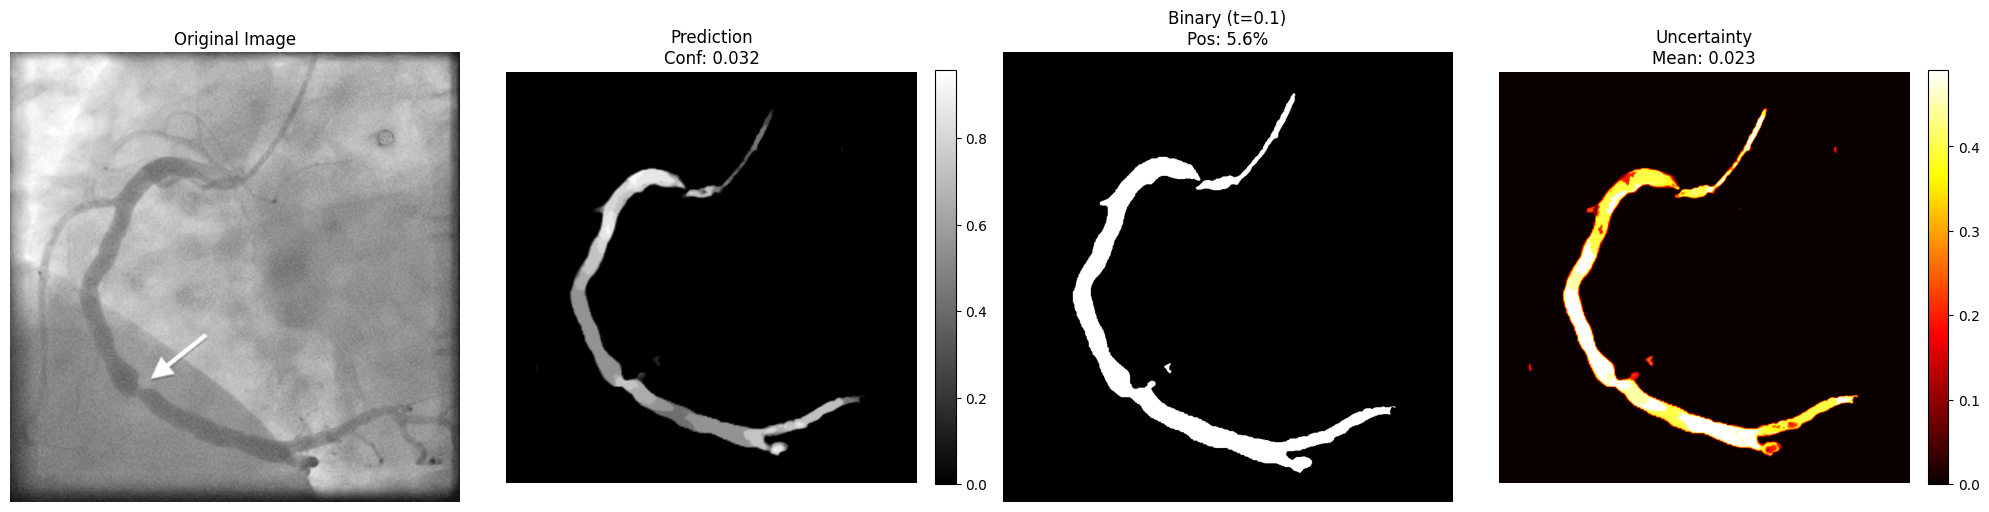

📊 CREATING COMPREHENSIVE INFERENCE REPORT
🎯 CREATING SCALE-INVARIANT INFERENCE
📂 Loading model from: /home/ives/rafal/from_repo/notebooks/best_multiscale_model.pth
🏗️ Model type: ResUNet
📊 Model performance:
   Best Dice: 0.6502
   Best F1: 0.6502
🔧 Training config:
   Progressive resizing: True
   Multi-scale loss: True
   Loss function: dice

⚙️ Inference configuration:
   Resolutions: [256, 320, 384, 448, 512]
   Weighting strategy: adaptive
   TTA enabled: True
   Uncertainty threshold: 0.1
🚀 EnhancedMultiResolutionInference initialized:
   Resolutions: [256, 320, 384, 448, 512]
   Weighting strategy: adaptive
   TTA enabled: True

✅ Scale-invariant inference ready!
🚀 Usage:
   prediction, uncertainty = inference_engine.predict(image)

🔄 Testing weighting strategies...
   Testing equal...
   Testing confidence...
   Testing resolution_weighted...
   Testing adaptive...

🔄 Testing TTA...

🔄 Analyzing resolution effects...


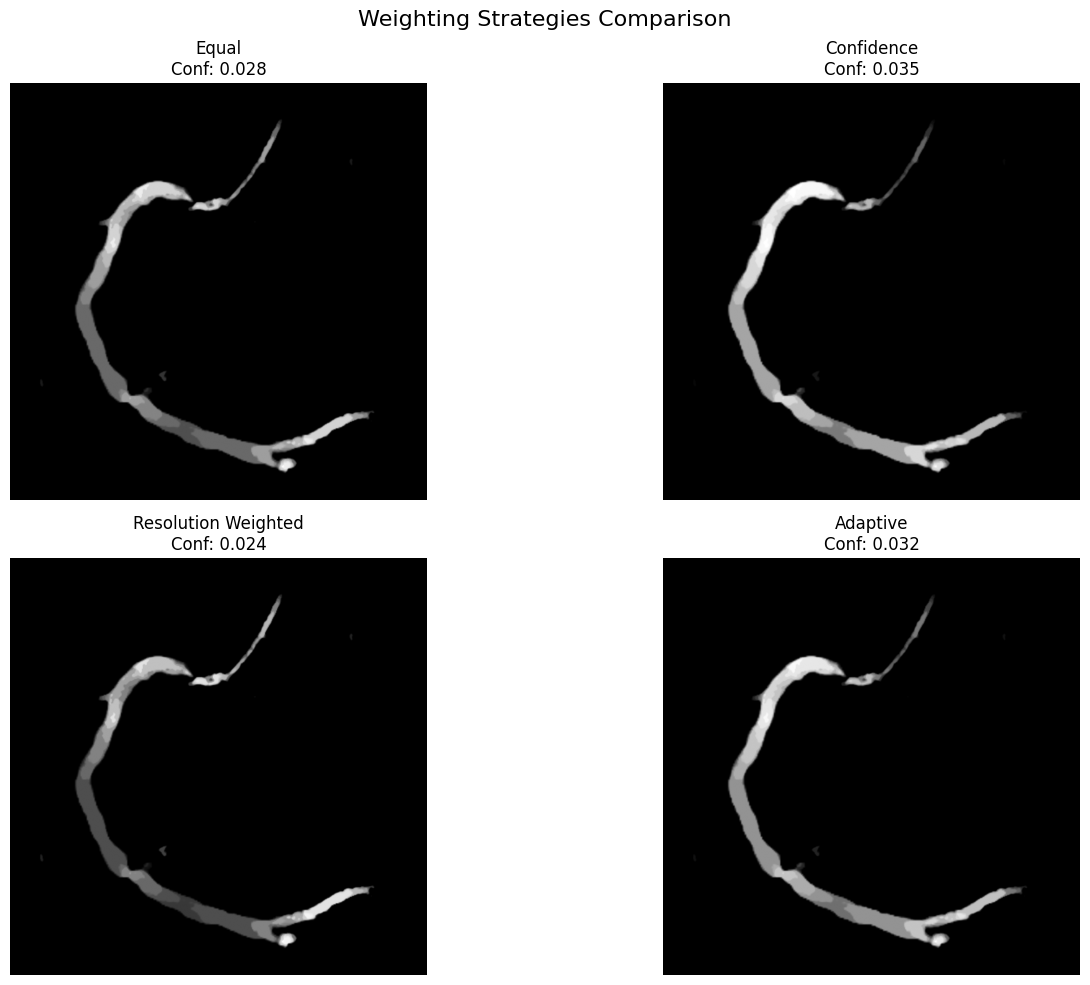

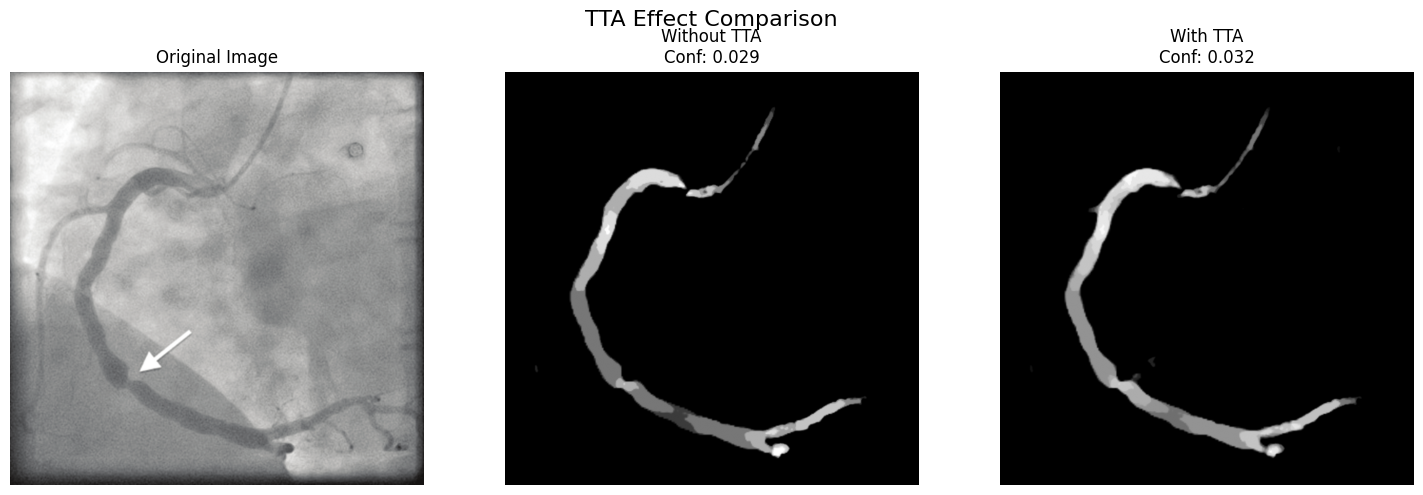


📋 INFERENCE REPORT SUMMARY:
----------------------------------------
🎯 Weighting Strategies:
   equal               : Conf=0.0276, Unc=0.0227
   confidence          : Conf=0.0346, Unc=0.0227
   resolution_weighted : Conf=0.0244, Unc=0.0227
   adaptive            : Conf=0.0320, Unc=0.0227

🔄 TTA Effect:
   Without TTA: 0.0294
   With TTA:    0.0320
   TTA benefit: 0.0025

📏 Resolution Variability:
   Std deviation: 0.0139
   Min/Max diff:  0.0355
   ✅ Low variability - single resolution might suffice

💾 Reports saved:
   - weighting_strategies_comparison.png
   - tta_comparison.png


{'prediction': array([[6.4470573e-06, 6.5788213e-06, 7.1060399e-06, ..., 4.2501792e-06,
         5.3561457e-06, 5.7561042e-06],
        [6.6416264e-06, 6.7778283e-06, 7.2996427e-06, ..., 4.0007103e-06,
         5.1721977e-06, 5.6094277e-06],
        [7.2142825e-06, 7.3440847e-06, 7.7246868e-06, ..., 3.3256833e-06,
         4.6342775e-06, 5.1397778e-06],
        ...,
        [3.1517087e-05, 2.8759468e-05, 2.2985883e-05, ..., 3.5335041e-05,
         4.2473526e-05, 4.5700475e-05],
        [2.9109888e-05, 2.8280147e-05, 2.6936283e-05, ..., 3.8992675e-05,
         3.9778603e-05, 4.0505267e-05],
        [2.8095181e-05, 2.8326644e-05, 2.8914132e-05, ..., 4.1056577e-05,
         3.9338109e-05, 3.8735172e-05]], dtype=float32),
 'binary_prediction': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'uncertainty': array([[8

In [ ]:
# 📊 OPTYMALNE PARAMETRY SCHEDULER DLA MULTISCALE TRAINING

def create_optimized_scheduler_configs():

    configs = {
        "conservative": {
            "name": "Conservative (bezpieczny)",
            "params": {
                "mode": "min",
                "factor": 0.7,      # Mniejsza redukcja LR
                "patience": 8,      # Większa cierpliwość
                "min_lr": 1e-7,
            },
            "description": "Powolne zmniejszanie LR, dobre dla stabilnego treningu"
        },
        
        "aggressive": {
            "name": "Aggressive (szybki)",
            "params": {
                "mode": "min", 
                "factor": 0.3,      # Większa redukcja LR
                "patience": 3,      # Mniejsza cierpliwość
                "min_lr": 1e-8,
            },
            "description": "Szybkie dostosowanie LR, może pomóc w fine-tuningu"
        },
        
        "balanced": {
            "name": "Balanced (zbalansowany)",
            "params": {
                "mode": "min",
                "factor": 0.5,      # Standardowa redukcja
                "patience": 5,      # Standardowa cierpliwość
                "min_lr": 1e-7,
                "threshold": 0.0001,  # Próg zmiany metryki
                "cooldown": 2        # Czas oczekiwania po redukcji
            },
            "description": "Dobrze zbalansowane parametry dla większości przypadków"
        },
        
        "multiscale_optimized": {
            "name": "Multiscale Optimized (zoptymalizowany)",
            "params": {
                "mode": "min",
                "factor": 0.6,      # Łagodna redukcja
                "patience": 6,      # Wyższa cierpliwość dla multi-scale
                "min_lr": 5e-8,
                "threshold": 0.0005, # Wyższy próg dla multi-scale noise
                "cooldown": 3,       # Dłuższy cooldown
                "eps": 1e-8         # Minimalna zmiana LR
            },
            "description": "Specjalnie dostosowany do multi-scale training z progresywnym resizing"
        }
    }
    
    for key, config in configs.items():
        print(f"\n{config['name']}:")
        print(f"   {config['description']}")
        print(f"   Parametry:")
        for param, value in config['params'].items():
            print(f"     {param}: {value}")
    
    return configs


def setup_multiscale_training_with_custom_scheduler(
    scheduler_type="balanced", 
    custom_scheduler_params=None,
    **training_params
):
    """
    Setup multiscale training z niestandardowym scheduler
    
    Args:
        scheduler_type: Typ schedulera ('conservative', 'aggressive', 'balanced', 'multiscale_optimized')
        custom_scheduler_params: Własne parametry schedulera
        **training_params: Inne parametry dla setup_multiscale_training
    """
    
    print(f"🔧 SETUP MULTISCALE TRAINING WITH {scheduler_type.upper()} SCHEDULER")
    print("="*60)
    
    # Pobierz konfiguracje
    configs = create_optimized_scheduler_configs()
    
    # Wybierz konfigurację
    if custom_scheduler_params:
        scheduler_params = custom_scheduler_params
        print("📝 Using custom scheduler parameters")
    elif scheduler_type in configs:
        scheduler_params = configs[scheduler_type]["params"]
        print(f"📋 Using {configs[scheduler_type]['name']} configuration")
    else:
        scheduler_params = configs["balanced"]["params"]
        print("Unknown scheduler type, using balanced")
    
    # Setup podstawowy
    setup = setup_multiscale_training(**training_params)
    
    # Zastąp scheduler
    print(f"\n🔄 Creating optimized scheduler...")
    setup['scheduler'] = ReduceLROnPlateau(
        setup['optimizer'], 
        **scheduler_params
    )
    
    print(f"✅ Scheduler configured:")
    for param, value in scheduler_params.items():
        print(f"   {param}: {value}")
    
    return setup


def recommend_scheduler_for_multiscale(
    epochs=50, 
    expected_convergence="medium",
    dataset_size="medium"
):
    """
    Rekomenduj scheduler na podstawie parametrów treningu
    
    Args:
        epochs: Liczba epok
        expected_convergence: "fast", "medium", "slow" 
        dataset_size: "small", "medium", "large"
    """
    
    print(f"🎯 SCHEDULER RECOMMENDATION")
    print(f"="*40)
    print(f"   Epochs: {epochs}")
    print(f"   Expected convergence: {expected_convergence}")
    print(f"   Dataset size: {dataset_size}")
    
    # Logika rekomendacji
    if epochs <= 20:
        if expected_convergence == "fast":
            recommended = "aggressive"
        else:
            recommended = "balanced"
    elif epochs <= 50:
        if dataset_size == "small":
            recommended = "conservative"
        elif expected_convergence == "slow":
            recommended = "multiscale_optimized"
        else:
            recommended = "balanced"
    else:  # epochs > 50
        if dataset_size == "large":
            recommended = "multiscale_optimized"
        else:
            recommended = "conservative"
    
    configs = create_optimized_scheduler_configs()
    
    print(f"\n✅ RECOMMENDED: {configs[recommended]['name']}")
    print(f"   {configs[recommended]['description']}")
    print(f"\n📋 Suggested parameters:")
    for param, value in configs[recommended]['params'].items():
        print(f"   {param}: {value}")
    
    print(f"\n🚀 Usage:")
    print(f"setup = setup_multiscale_training_with_custom_scheduler(")
    print(f"    scheduler_type='{recommended}',")
    print(f"    epochs={epochs}")
    print(f")")
    
    return recommended, configs[recommended]['params']


def example_multiscale_training_configs():
    """
    Przykłady różnych konfiguracji treningu
    """
    
    print("📋 EXAMPLE MULTISCALE TRAINING CONFIGURATIONS")
    print("="*60)
    
    examples = {
        "quick_test": {
            "epochs": 10,
            "scheduler_type": "aggressive", 
            "use_progressive": False,
            "batch_size": 32,
            "description": "Szybki test - małe epochs, agresywny scheduler"
        },
        
        "development": {
            "epochs": 30,
            "scheduler_type": "balanced",
            "use_progressive": True,
            "batch_size": 16,
            "description": "Rozwój modelu - średnie epochs, zbalansowany scheduler"
        },
        
        "production": {
            "epochs": 80,
            "scheduler_type": "multiscale_optimized",
            "use_progressive": True,
            "use_multiscale_loss": True,
            "batch_size": 8,
            "description": "Produkcyjny trening - długie epochs, optymalizowany scheduler"
        },
        
        "fine_tuning": {
            "epochs": 20,
            "scheduler_type": "conservative",
            "use_progressive": False,
            "lr": 0.0001,  # Niższy LR
            "batch_size": 16,
            "description": "Fine-tuning - konserwatywny scheduler, niski LR"
        }
    }
    
    for name, config in examples.items():
        print(f"\n🎯 {name.upper()}:")
        print(f"   {config['description']}")
        print(f"   Setup code:")
        print(f"   setup = setup_multiscale_training_with_custom_scheduler(")
        for key, value in config.items():
            if key != 'description':
                if isinstance(value, str):
                    print(f"       {key}='{value}',")
                else:
                    print(f"       {key}={value},")
        print(f"   )")
        print(f"   model, history = train_model_multiscale(**setup)")


print("✅ SCHEDULER CONFIGURATION TOOLS READY!")
print("\n🚀 Available functions:")
print("# Show all configurations:")
print("create_optimized_scheduler_configs()")
print("")
print("# Get recommendation:")
print("recommend_scheduler_for_multiscale(epochs=50, expected_convergence='medium')")
print("")
print("# Setup with custom scheduler:")
print("setup = setup_multiscale_training_with_custom_scheduler('balanced')")
print("")
print("# See examples:")
print("example_multiscale_training_configs()")

✅ SCHEDULER CONFIGURATION TOOLS READY!

🚀 Available functions:
# Show all configurations:
create_optimized_scheduler_configs()

# Get recommendation:
recommend_scheduler_for_multiscale(epochs=50, expected_convergence='medium')

# Setup with custom scheduler:
setup = setup_multiscale_training_with_custom_scheduler('balanced')

# See examples:
example_multiscale_training_configs()


In [97]:
setup = setup_multiscale_training_with_custom_scheduler('multiscale_optimized')
example_multiscale_training_configs()

🔧 SETUP MULTISCALE TRAINING WITH MULTISCALE_OPTIMIZED SCHEDULER

Conservative (bezpieczny):
   Powolne zmniejszanie LR, dobre dla stabilnego treningu
   Parametry:
     mode: min
     factor: 0.7
     patience: 8
     min_lr: 1e-07

Aggressive (szybki):
   Szybkie dostosowanie LR, może pomóc w fine-tuningu
   Parametry:
     mode: min
     factor: 0.3
     patience: 3
     min_lr: 1e-08

Balanced (zbalansowany):
   Dobrze zbalansowane parametry dla większości przypadków
   Parametry:
     mode: min
     factor: 0.5
     patience: 5
     min_lr: 1e-07
     threshold: 0.0001
     cooldown: 2

Multiscale Optimized (zoptymalizowany):
   Specjalnie dostosowany do multi-scale training z progresywnym resizing
   Parametry:
     mode: min
     factor: 0.6
     patience: 6
     min_lr: 5e-08
     threshold: 0.0005
     cooldown: 3
     eps: 1e-08
📋 Using Multiscale Optimized (zoptymalizowany) configuration
🔧 SETTING UP MULTI-SCALE TRAINING
📊 Dataset split:
   Train: 800 images
   Validation: 20

In [98]:
model, history = train_model_multiscale(**setup)

🚀 MULTI-SCALE TRAINING STARTED
🔧 Configuration:
   Epochs: 100
   Batch size: 32
   Progressive resizing: True
   Multi-scale loss: True
   Base loss: dice
   TensorBoard: True
   TensorBoard logs: runs/multiscale_dice_20250729_182001_progressive_multiscale_loss
   Run: tensorboard --logdir=runs
🎯 Progressive resizing initialized:
   Phases: [256, 320, 384, 448]
   Switch epochs: [25, 50, 75]

📊 TRAINING PROGRESS:
--------------------------------------------------------------------------------
📈 Epoch 0: Setting resolution to 256


Epoch 1/100 [TRAIN]:   0%|          | 0/25 [00:00<?, ?it/s]/tmp/ipykernel_285045/4242882646.py:104: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(
Epoch 1/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it, Loss=1.5513, Dice=0.1135]



Epoch 1/100 Summary:
  Resolution: 256x256
  Train Loss: 1.3127
  Val Loss: 1.5513
  Val Dice: 0.1135
  Val F1: 0.1135
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 2/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it, Loss=1.1501, Dice=0.3462]



Epoch 2/100 Summary:
  Resolution: 256x256
  Train Loss: 1.0295
  Val Loss: 1.1501
  Val Dice: 0.3462
  Val F1: 0.3462
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 3/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=1.5047, Dice=0.1409]



Epoch 3/100 Summary:
  Resolution: 256x256
  Train Loss: 0.9336
  Val Loss: 1.5047
  Val Dice: 0.1409
  Val F1: 0.1409
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 4/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=1.5036, Dice=0.1416]



Epoch 4/100 Summary:
  Resolution: 256x256
  Train Loss: 0.8918
  Val Loss: 1.5036
  Val Dice: 0.1416
  Val F1: 0.1416
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 5/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=1.5811, Dice=0.0967]



Epoch 5/100 Summary:
  Resolution: 256x256
  Train Loss: 0.8497
  Val Loss: 1.5811
  Val Dice: 0.0967
  Val F1: 0.0967
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 6/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.68s/it, Loss=1.3056, Dice=0.2559]



Epoch 6/100 Summary:
  Resolution: 256x256
  Train Loss: 0.8019
  Val Loss: 1.3056
  Val Dice: 0.2559
  Val F1: 0.2559
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 7/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=1.4459, Dice=0.1750]



Epoch 7/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7632
  Val Loss: 1.4459
  Val Dice: 0.1750
  Val F1: 0.1750
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 8/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.2903, Dice=0.2658]



Epoch 8/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7668
  Val Loss: 1.2903
  Val Dice: 0.2658
  Val F1: 0.2658
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 9/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.0807, Dice=0.3851]



Epoch 9/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7643
  Val Loss: 1.0807
  Val Dice: 0.3851
  Val F1: 0.3851
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 10/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.6229, Dice=0.0733]



Epoch 10/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7282
  Val Loss: 1.6229
  Val Dice: 0.0733
  Val F1: 0.0733
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 11/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.9240, Dice=0.4752]



Epoch 11/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7350
  Val Loss: 0.9240
  Val Dice: 0.4752
  Val F1: 0.4752
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 12/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.1815, Dice=0.3273]



Epoch 12/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7085
  Val Loss: 1.1815
  Val Dice: 0.3273
  Val F1: 0.3273
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 13/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it, Loss=1.6278, Dice=0.0700]



Epoch 13/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6846
  Val Loss: 1.6278
  Val Dice: 0.0700
  Val F1: 0.0700
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 14/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.65s/it, Loss=1.1102, Dice=0.3684]



Epoch 14/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7006
  Val Loss: 1.1102
  Val Dice: 0.3684
  Val F1: 0.3684
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 15/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.1195, Dice=0.3628]



Epoch 15/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6944
  Val Loss: 1.1195
  Val Dice: 0.3628
  Val F1: 0.3628
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 16/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8279, Dice=0.5299]



Epoch 16/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7073
  Val Loss: 0.8279
  Val Dice: 0.5299
  Val F1: 0.5299
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 17/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8320, Dice=0.5272]



Epoch 17/100 Summary:
  Resolution: 256x256
  Train Loss: 0.7122
  Val Loss: 0.8320
  Val Dice: 0.5272
  Val F1: 0.5272
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 18/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.5159, Dice=0.1336]



Epoch 18/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6956
  Val Loss: 1.5159
  Val Dice: 0.1336
  Val F1: 0.1336
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 19/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8205, Dice=0.5338]



Epoch 19/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6877
  Val Loss: 0.8205
  Val Dice: 0.5338
  Val F1: 0.5338
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 20/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.5620, Dice=0.1070]



Epoch 20/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6685
  Val Loss: 1.5620
  Val Dice: 0.1070
  Val F1: 0.1070
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 21/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.4683, Dice=0.1615]



Epoch 21/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6516
  Val Loss: 1.4683
  Val Dice: 0.1615
  Val F1: 0.1615
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 22/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8155, Dice=0.5374]



Epoch 22/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6792
  Val Loss: 0.8155
  Val Dice: 0.5374
  Val F1: 0.5374
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 23/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8020, Dice=0.5447]



Epoch 23/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6672
  Val Loss: 0.8020
  Val Dice: 0.5447
  Val F1: 0.5447
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 24/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8899, Dice=0.4946]



Epoch 24/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6609
  Val Loss: 0.8899
  Val Dice: 0.4946
  Val F1: 0.4946
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 25/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.7312, Dice=0.5852]



Epoch 25/100 Summary:
  Resolution: 256x256
  Train Loss: 0.6547
  Val Loss: 0.7312
  Val Dice: 0.5852
  Val F1: 0.5852
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------
📈 Epoch 25: Switching resolution 256 → 320


Epoch 26/100 [TRAIN]:   0%|          | 0/25 [00:00<?, ?it/s]/home/ives/rafal/from_repo/notebooks/venv/lib/python3.12/site-packages/albumentations/augmentations/blur/functional.py:232: UserWarning: blur_limit: Non-zero kernel sizes must be odd. Range (3, 6) automatically adjusted to (3, 7).
  result = _ensure_odd_values(result, info.field_name)
Epoch 26/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6785, Dice=0.6159]



Epoch 26/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6750
  Val Loss: 0.6785
  Val Dice: 0.6159
  Val F1: 0.6159
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 27/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6567, Dice=0.6283]



Epoch 27/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6792
  Val Loss: 0.6567
  Val Dice: 0.6283
  Val F1: 0.6283
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 28/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=1.0177, Dice=0.4203]



Epoch 28/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6568
  Val Loss: 1.0177
  Val Dice: 0.4203
  Val F1: 0.4203
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 29/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6803, Dice=0.6145]



Epoch 29/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6582
  Val Loss: 0.6803
  Val Dice: 0.6145
  Val F1: 0.6145
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 30/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.7337, Dice=0.5838]



Epoch 30/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6404
  Val Loss: 0.7337
  Val Dice: 0.5838
  Val F1: 0.5838
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 31/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.7438, Dice=0.5776]



Epoch 31/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6516
  Val Loss: 0.7438
  Val Dice: 0.5776
  Val F1: 0.5776
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 32/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6774, Dice=0.6165]



Epoch 32/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6492
  Val Loss: 0.6774
  Val Dice: 0.6165
  Val F1: 0.6165
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 33/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.7463, Dice=0.5763]



Epoch 33/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6419
  Val Loss: 0.7463
  Val Dice: 0.5763
  Val F1: 0.5763
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 34/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6507, Dice=0.6318]



Epoch 34/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6385
  Val Loss: 0.6507
  Val Dice: 0.6318
  Val F1: 0.6318
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 35/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6423, Dice=0.6364]



Epoch 35/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6432
  Val Loss: 0.6423
  Val Dice: 0.6364
  Val F1: 0.6364
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 36/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6738, Dice=0.6181]



Epoch 36/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6328
  Val Loss: 0.6738
  Val Dice: 0.6181
  Val F1: 0.6181
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 37/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6400, Dice=0.6377]



Epoch 37/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6306
  Val Loss: 0.6400
  Val Dice: 0.6377
  Val F1: 0.6377
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 38/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.8047, Dice=0.5432]



Epoch 38/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6297
  Val Loss: 0.8047
  Val Dice: 0.5432
  Val F1: 0.5432
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 39/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6434, Dice=0.6360]



Epoch 39/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6308
  Val Loss: 0.6434
  Val Dice: 0.6360
  Val F1: 0.6360
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 40/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.7451, Dice=0.5771]



Epoch 40/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6287
  Val Loss: 0.7451
  Val Dice: 0.5771
  Val F1: 0.5771
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 41/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6408, Dice=0.6376]



Epoch 41/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6365
  Val Loss: 0.6408
  Val Dice: 0.6376
  Val F1: 0.6376
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 42/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6262, Dice=0.6458]



Epoch 42/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6366
  Val Loss: 0.6262
  Val Dice: 0.6458
  Val F1: 0.6458
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 43/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=0.6630, Dice=0.6243]



Epoch 43/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6259
  Val Loss: 0.6630
  Val Dice: 0.6243
  Val F1: 0.6243
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 44/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=0.6185, Dice=0.6502]



Epoch 44/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6300
  Val Loss: 0.6185
  Val Dice: 0.6502
  Val F1: 0.6502
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 45/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6711, Dice=0.6200]



Epoch 45/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6298
  Val Loss: 0.6711
  Val Dice: 0.6200
  Val F1: 0.6200
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 46/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6360, Dice=0.6398]



Epoch 46/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6251
  Val Loss: 0.6360
  Val Dice: 0.6398
  Val F1: 0.6398
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 47/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=0.7536, Dice=0.5722]



Epoch 47/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6395
  Val Loss: 0.7536
  Val Dice: 0.5722
  Val F1: 0.5722
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 48/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.67s/it, Loss=0.7140, Dice=0.5951]



Epoch 48/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6207
  Val Loss: 0.7140
  Val Dice: 0.5951
  Val F1: 0.5951
  LR: 0.010000
--------------------------------------------------------------------------------


Epoch 49/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6178, Dice=0.6502]



Epoch 49/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6174
  Val Loss: 0.6178
  Val Dice: 0.6502
  Val F1: 0.6502
  LR: 0.010000
✅ Best model saved: best_multiscale_model.pth
--------------------------------------------------------------------------------


Epoch 50/100 [VAL]: 100%|██████████| 7/7 [00:11<00:00,  1.66s/it, Loss=0.6457, Dice=0.6346]



Epoch 50/100 Summary:
  Resolution: 320x320
  Train Loss: 0.6205
  Val Loss: 0.6457
  Val Dice: 0.6346
  Val F1: 0.6346
  LR: 0.010000
--------------------------------------------------------------------------------
📈 Epoch 50: Switching resolution 320 → 384


Epoch 51/100 [TRAIN]:   0%|          | 0/25 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.12 GiB. GPU 0 has a total capacity of 31.35 GiB of which 167.38 MiB is free. Including non-PyTorch memory, this process has 30.49 GiB memory in use. Of the allocated memory 26.96 GiB is allocated by PyTorch, and 2.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# 🚀 ENHANCED MULTI-RESOLUTION INFERENCE ENGINE

class EnhancedMultiResolutionInference:
    """
    Ulepszona klasa do inference z wieloma rozdzielczościami
    
    Features:
    - Ensemble z różnych rozdzielczości
    - Test Time Augmentation (TTA)
    - Adaptacyjne ważenie wyników
    - Estymacja niepewności
    - Obsługa różnych strategii kombinowania
    """
    
    def __init__(self, model, resolutions=[256, 320, 384], 
                 weights='adaptive', enable_tta=True, uncertainty_threshold=0.1):
        """
        Args:
            model: Wytrenowany model PyTorch
            resolutions: Lista rozdzielczości do testowania
            weights: Strategia ważenia ('equal', 'adaptive', 'confidence', 'resolution_weighted')
            enable_tta: Czy włączyć Test Time Augmentation
            uncertainty_threshold: Próg niepewności dla adaptacyjnego ważenia
        """
        self.model = model.to(device)
        self.model.eval()
        self.resolutions = resolutions
        self.weights = weights
        self.enable_tta = enable_tta
        self.uncertainty_threshold = uncertainty_threshold
        
        print(f"🚀 EnhancedMultiResolutionInference initialized:")
        print(f"   Resolutions: {resolutions}")
        print(f"   Weighting strategy: {weights}")
        print(f"   TTA enabled: {enable_tta}")
    
    def predict(self, image):
        """
        Główna metoda predykcji z ensemble
        
        Args:
            image: numpy array (H, W) grayscale LUB (H, W, C) RGB
                  Jeśli RGB - automatycznie konwertowane do grayscale
            
        Returns:
            prediction: numpy array - finalna predykcja
            uncertainty: numpy array - mapa niepewności
        """
        
        # Lista predykcji z różnych rozdzielczości
        predictions = []
        confidences = []
        
        original_size = image.shape[:2]
        
        for resolution in self.resolutions:
            # Predykcja dla danej rozdzielczości
            pred, conf = self._predict_single_resolution(image, resolution)
            predictions.append(pred)
            confidences.append(conf)
        
        # Kombinuj wyniki
        final_prediction, uncertainty = self._combine_predictions(
            predictions, confidences, original_size
        )
        
        return final_prediction, uncertainty
    
    def _predict_single_resolution(self, image, resolution):
        """
        Predykcja dla pojedynczej rozdzielczości
        """
        
        # Konwertuj RGB na grayscale jeśli potrzeba
        if len(image.shape) == 3 and image.shape[2] == 3:
            # Konwersja RGB do grayscale
            image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            image_gray = image
        
        # Przygotuj transformacje dla grayscale
        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((resolution, resolution)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # Grayscale normalization
        ])
        
        predictions = []
        
        # Podstawowa predykcja
        input_tensor = transform(image_gray).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = self.model(input_tensor)
            prediction = torch.sigmoid(output).squeeze().cpu().numpy()
            predictions.append(prediction)
        
        # Test Time Augmentation jeśli włączone
        if self.enable_tta:
            # Horizontal flip
            flipped_image = cv2.flip(image_gray, 1)  # Flip horizontally
            input_tensor_flip = transform(flipped_image).unsqueeze(0).to(device)
            
            with torch.no_grad():
                output_flip = self.model(input_tensor_flip)
                pred_flip = torch.sigmoid(output_flip).squeeze().cpu().numpy()
                # Flip back the prediction
                pred_flip = cv2.flip(pred_flip, 1)
                predictions.append(pred_flip)
        
        # Średnia z TTA
        final_pred = np.mean(predictions, axis=0)
        confidence = np.mean(final_pred)
        
        return final_pred, confidence
    
    def _combine_predictions(self, predictions, confidences, target_size):
        """
        Kombinuj predykcje z różnych rozdzielczości
        """
        
        # Resize wszystkich predykcji do target_size
        resized_predictions = []
        for pred in predictions:
            resized = cv2.resize(pred, (target_size[1], target_size[0]))
            resized_predictions.append(resized)
        
        resized_predictions = np.array(resized_predictions)
        
        # Wybierz strategię ważenia
        if self.weights == 'equal':
            weights = np.ones(len(predictions)) / len(predictions)
        elif self.weights == 'confidence':
            weights = np.array(confidences)
            weights = weights / np.sum(weights)
        elif self.weights == 'resolution_weighted':
            # Wyższe rozdzielczości mają większą wagę
            res_weights = np.array(self.resolutions) / np.sum(self.resolutions)
            weights = res_weights
        elif self.weights == 'adaptive':
            # Adaptacyjne ważenie bazujące na niepewności
            weights = self._compute_adaptive_weights(resized_predictions, confidences)
        else:
            weights = np.ones(len(predictions)) / len(predictions)
        
        # Ważona średnia
        final_prediction = np.average(resized_predictions, axis=0, weights=weights)
        
        # Oblicz niepewność jako std predykcji
        uncertainty = np.std(resized_predictions, axis=0)
        
        return final_prediction, uncertainty
    
    def _compute_adaptive_weights(self, predictions, confidences):
        """
        Oblicz adaptacyjne wagi bazujące na niepewności i confidence
        """
        
        # Oblicz niepewność dla każdej predykcji
        uncertainties = []
        for pred in predictions:
            # Niepewność jako entropy
            epsilon = 1e-7
            entropy = -pred * np.log(pred + epsilon) - (1 - pred) * np.log(1 - pred + epsilon)
            avg_uncertainty = np.mean(entropy)
            uncertainties.append(avg_uncertainty)
        
        uncertainties = np.array(uncertainties)
        confidences = np.array(confidences)
        
        # Wagi odwrotnie proporcjonalne do niepewności
        uncertainty_weights = 1.0 / (uncertainties + 1e-7)
        
        # Kombinuj z confidence
        combined_weights = uncertainty_weights * confidences
        
        # Normalizuj
        weights = combined_weights / np.sum(combined_weights)
        
        return weights
    
    def ensemble_inference(self, image_path, threshold=0.5, weight_strategy=None, tta=None):
        """
        Metoda ensemble inference z dodatkową konfiguracją
        """
        
        if weight_strategy is not None:
            original_weights = self.weights
            self.weights = weight_strategy
        
        if tta is not None:
            original_tta = self.enable_tta
            self.enable_tta = tta
        
        # Wczytaj obraz
        if isinstance(image_path, str):
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Konwertuj do grayscale dla modelu
            image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
        else:
            # Jeśli przekazano numpy array
            if len(image_path.shape) == 3 and image_path.shape[2] == 3:
                image_rgb = image_path
                image_gray = cv2.cvtColor(image_path, cv2.COLOR_RGB2GRAY)
            else:
                image_gray = image_path
                # Dla wizualizacji stwórz RGB z grayscale
                image_rgb = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
        
        # Predykcja na grayscale
        prediction, uncertainty = self.predict(image_gray)
        
        # Threshold
        binary_prediction = (prediction > threshold).astype(np.uint8)
        
        # Statystyki
        stats = {
            'mean_confidence': np.mean(prediction),
            'max_confidence': np.max(prediction),
            'min_confidence': np.min(prediction),
            'uncertainty_mean': np.mean(uncertainty),
            'uncertainty_max': np.max(uncertainty),
            'positive_ratio': np.sum(binary_prediction) / binary_prediction.size,
            'threshold': threshold
        }
        
        # Przywróć oryginalne ustawienia
        if weight_strategy is not None:
            self.weights = original_weights
        if tta is not None:
            self.enable_tta = original_tta
        
        return {
            'prediction': prediction,
            'binary_prediction': binary_prediction,
            'uncertainty': uncertainty,
            'stats': stats,
            'original_image': image_rgb  # Zawsze RGB dla wizualizacji
        }
    
    def get_resolution_comparison(self, image):
        """
        Porównaj wyniki dla każdej rozdzielczości osobno
        """
        
        results = {}
        
        for resolution in self.resolutions:
            pred, conf = self._predict_single_resolution(image, resolution)
            
            # Resize do oryginalnego rozmiaru
            target_size = image.shape[:2]
            resized_pred = cv2.resize(pred, (target_size[1], target_size[0]))
            
            results[resolution] = {
                'prediction': resized_pred,
                'confidence': conf,
                'positive_ratio': np.sum(resized_pred > 0.5) / resized_pred.size
            }
        
        return results

def create_scale_invariant_inference(model_path, 
                                   resolutions=[256, 320, 384, 448, 512],
                                   weights='adaptive',
                                   enable_tta=True,
                                   uncertainty_threshold=0.1):
    """
    Stwórz instancję EnhancedMultiResolutionInference z najlepszymi ustawieniami
    
    Args:
        model_path: Ścieżka do zapisanego modelu
        resolutions: Lista rozdzielczości do ensemble
        weights: Strategia ważenia ('equal', 'adaptive', 'confidence')
        enable_tta: Czy włączyć Test Time Augmentation
        uncertainty_threshold: Próg niepewności dla adaptacyjnego ważenia
    
    Returns:
        EnhancedMultiResolutionInference: Gotowa instancja do inferencji
    """
    
    print(f"🎯 CREATING SCALE-INVARIANT INFERENCE")
    print(f"="*50)
    
    # Wczytaj model
    if os.path.exists(model_path):
        print(f"📂 Loading model from: {model_path}")
        
        # Wczytaj checkpoint
        checkpoint = torch.load(model_path, map_location='cpu')
        
        # Sprawdź typ modelu
        if 'model_type' in checkpoint:
            model_type = checkpoint['model_type']
            print(f"🏗️ Model type: {model_type}")
        else:
            print("⚠️ Model type not found in checkpoint, using enhanced_unet")
            model_type = 'enhanced_unet'
        
        # Stwórz model
        model = create_model(model_type, n_class=1)
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Informacje o modelu
        if 'metrics' in checkpoint:
            metrics = checkpoint['metrics']
            print(f"📊 Model performance:")
            print(f"   Best Dice: {metrics.get('fg_dice', 'N/A'):.4f}")
            print(f"   Best F1: {metrics.get('f1', 'N/A'):.4f}")
        
        if 'config' in checkpoint:
            config = checkpoint['config']
            print(f"🔧 Training config:")
            print(f"   Progressive resizing: {config.get('use_progressive_resizing', 'N/A')}")
            print(f"   Multi-scale loss: {config.get('use_multiscale_loss', 'N/A')}")
            print(f"   Loss function: {config.get('loss_function', 'N/A')}")
    else:
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Konfiguracja inference
    print(f"\n⚙️ Inference configuration:")
    print(f"   Resolutions: {resolutions}")
    print(f"   Weighting strategy: {weights}")
    print(f"   TTA enabled: {enable_tta}")
    print(f"   Uncertainty threshold: {uncertainty_threshold}")
    
    # Stwórz inference engine
    inference_engine = EnhancedMultiResolutionInference(
        model=model,
        resolutions=resolutions,
        weights=weights,
        enable_tta=enable_tta,
        uncertainty_threshold=uncertainty_threshold
    )
    
    print(f"\n✅ Scale-invariant inference ready!")
    print(f"🚀 Usage:")
    print(f"   prediction, uncertainty = inference_engine.predict(image)")
    
    return inference_engine

def visualize_ensemble_results(results, save_path=None, figsize=(20, 5)):
    """
    Wizualizuj wyniki ensemble inference
    
    Args:
        results: Wyniki z ensemble_inference()
        save_path: Ścieżka do zapisania (opcjonalna)
        figsize: Rozmiar figury
    """
    
    fig, axes = plt.subplots(1, 4, figsize=figsize)
    
    # Original image
    axes[0].imshow(results['original_image'])
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Prediction (continuous)
    im1 = axes[1].imshow(results['prediction'], cmap='gray')
    axes[1].set_title(f"Prediction\nConf: {results['stats']['mean_confidence']:.3f}")
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    # Binary prediction
    axes[2].imshow(results['binary_prediction'], cmap='gray')
    axes[2].set_title(f"Binary (t={results['stats']['threshold']})\nPos: {results['stats']['positive_ratio']:.1%}")
    axes[2].axis('off')
    
    # Uncertainty map
    im3 = axes[3].imshow(results['uncertainty'], cmap='hot')
    axes[3].set_title(f"Uncertainty\nMean: {results['stats']['uncertainty_mean']:.3f}")
    axes[3].axis('off')
    plt.colorbar(im3, ax=axes[3], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Visualization saved: {save_path}")
    
    plt.show()


def visualize_resolution_comparison(image, inference_engine, save_path=None):
    """
    Wizualizuj porównanie różnych rozdzielczości
    """
    
    results = inference_engine.get_resolution_comparison(image)
    resolutions = list(results.keys())
    
    fig, axes = plt.subplots(2, len(resolutions), figsize=(20, 8))
    
    for i, resolution in enumerate(resolutions):
        result = results[resolution]
        
        # Prediction
        axes[0, i].imshow(result['prediction'], cmap='gray')
        axes[0, i].set_title(f"{resolution}x{resolution}\nConf: {result['confidence']:.3f}")
        axes[0, i].axis('off')
        
        # Histogram
        axes[1, i].hist(result['prediction'].flatten(), bins=50, alpha=0.7, color='blue')
        axes[1, i].set_title(f"Histogram {resolution}")
        axes[1, i].set_xlabel("Confidence")
        axes[1, i].set_ylabel("Frequency")
        axes[1, i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"💾 Resolution comparison saved: {save_path}")
    
    plt.show()
    
    return results


def create_inference_comparison_report(image_path, model_path):
    """
    Stwórz kompletny raport porównawczy inference
    """
    
    print("📊 CREATING COMPREHENSIVE INFERENCE REPORT")
    print("="*60)
    
    # Wczytaj obraz
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Stwórz inference engine
    engine = create_scale_invariant_inference(model_path)
    
    # 1. Test różnych strategii ważenia
    strategies = ['equal', 'confidence', 'resolution_weighted', 'adaptive']
    strategy_results = {}
    
    print("\n🔄 Testing weighting strategies...")
    for strategy in strategies:
        print(f"   Testing {strategy}...")
        results = engine.ensemble_inference(image, weight_strategy=strategy)
        strategy_results[strategy] = results
    
    # 2. Test z/bez TTA
    print("\n🔄 Testing TTA...")
    results_no_tta = engine.ensemble_inference(image, tta=False)
    results_with_tta = engine.ensemble_inference(image, tta=True)
    
    # 3. Resolution comparison
    print("\n🔄 Analyzing resolution effects...")
    resolution_results = engine.get_resolution_comparison(image)
    
    # Wizualizacja strategii ważenia
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, strategy in enumerate(strategies):
        result = strategy_results[strategy]
        axes[i].imshow(result['prediction'], cmap='gray')
        axes[i].set_title(f"{strategy.replace('_', ' ').title()}\nConf: {result['stats']['mean_confidence']:.3f}")
        axes[i].axis('off')
    
    plt.suptitle("Weighting Strategies Comparison", fontsize=16)
    plt.tight_layout()
    plt.savefig("weighting_strategies_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # TTA comparison
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(results_no_tta['prediction'], cmap='gray')
    axes[1].set_title(f"Without TTA\nConf: {results_no_tta['stats']['mean_confidence']:.3f}")
    axes[1].axis('off')
    
    axes[2].imshow(results_with_tta['prediction'], cmap='gray')
    axes[2].set_title(f"With TTA\nConf: {results_with_tta['stats']['mean_confidence']:.3f}")
    axes[2].axis('off')
    
    plt.suptitle("TTA Effect Comparison", fontsize=16)
    plt.tight_layout()
    plt.savefig("tta_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    # Raport końcowy
    print("\n📋 INFERENCE REPORT SUMMARY:")
    print("-" * 40)
    
    print("🎯 Weighting Strategies:")
    for strategy, result in strategy_results.items():
        conf = result['stats']['mean_confidence']
        uncertainty = result['stats']['uncertainty_mean']
        print(f"   {strategy:20s}: Conf={conf:.4f}, Unc={uncertainty:.4f}")
    
    print(f"\n🔄 TTA Effect:")
    print(f"   Without TTA: {results_no_tta['stats']['mean_confidence']:.4f}")
    print(f"   With TTA:    {results_with_tta['stats']['mean_confidence']:.4f}")
    print(f"   TTA benefit: {abs(results_with_tta['stats']['mean_confidence'] - results_no_tta['stats']['mean_confidence']):.4f}")
    
    print(f"\n📏 Resolution Variability:")
    confidences = [r['confidence'] for r in resolution_results.values()]
    print(f"   Std deviation: {np.std(confidences):.4f}")
    print(f"   Min/Max diff:  {max(confidences) - min(confidences):.4f}")
    
    if np.std(confidences) > 0.05:
        print("   ⚠️  High variability - multi-scale highly recommended!")
    else:
        print("   ✅ Low variability - single resolution might suffice")
    
    print("\n💾 Reports saved:")
    print("   - weighting_strategies_comparison.png")
    print("   - tta_comparison.png")
    
    return {
        'strategy_results': strategy_results,
        'tta_comparison': {'no_tta': results_no_tta, 'with_tta': results_with_tta},
        'resolution_results': resolution_results
    }


print("✅ ENHANCED MULTI-RESOLUTION INFERENCE READY!")
print("\n🚀 Quick start:")
print("# Create inference engine")
print("engine = create_scale_invariant_inference('model.pth')")
print("")
print("# Basic prediction")
print("prediction, uncertainty = engine.predict(image)")
print("")
print("# Ensemble with configuration")
print("results = engine.ensemble_inference(image_path, threshold=0.5)")
print("")
print("# Visualize results")
print("visualize_ensemble_results(results)")
print("")
print("# Full comparison report")
print("report = create_inference_comparison_report(image_path, model_path)")

